In [1]:
import os
import tensorflow as tf
import pydicom
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input,MaxPool3D,Conv3D,Dense,BatchNormalization,Flatten
from tensorflow.keras.layers import GlobalAveragePooling3D,concatenate
from tensorflow.keras.utils import plot_model
from xml.etree import ElementTree as ET
from tensorflow.keras.layers import *
import pandas as pd
import matplotlib.patches as patches

In [2]:
tf.__version__

'2.3.0'

In [2]:
!pip install pandas
!pip install pydicom
!pip install scikit-learn

     |████████████████████████████████| 10.5 MB 411 kB/s eta 0:00:01
     |████████████████████████████████| 510 kB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 35.4 MB 239 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 6.8 MB 876 kB/s eta 0:00:01
     |████████████████████████████████| 300 kB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
def get_label_index(xml_path,IDs):
    xml_file = ET.parse(xml_path)
    n = len(IDs)
    scores = []
    for i in range(len(IDs)):
        s = read_malignancy_score(xml_file,IDs[i])
        if s != 0 and s != None :
            scores.append(s)
    if len(scores ) < 3:
        return None,None
    scores = np.array(scores,dtype=np.uint8)
    median = np.median(scores)
    if median == 3:
        return None,None
    label = 0
    if median > 3:
        label = 1
    return median,label

In [3]:
def read_malignancy_score(XML_file,Nodule_ID):
    root = XML_file.getroot()
    score = None
    for f1 in root:
        if 'readingSession' in f1.tag :
            for f2 in f1:
               if 'unblindedReadNodule' in f2.tag:
                    for f3 in f2:
                        if 'noduleID' in f3.tag and f3.text == Nodule_ID:
                            for f4 in f2:
                                if 'characteristics' in f4.tag:
                                  for f5 in f4:
                                      if 'malignancy' in f5.tag:
                                          score = f5.text
    return score

In [4]:
def XML_for_index(case ,CT_dir,scan):
    xmls = {}
    scan = str(scan)
    for di in CT_dir[case]:
        arc = os.listdir(di)
        for i in arc:
            if i[-3:] == 'xml':
                xmls[di] = i
    out = None           
    for i in xmls:
        if scan in i:
            out = os.path.join(i,xmls[i])
    return out 

In [5]:
def size(case,CT_dir,scan):
    scan = str(scan)
    for di in CT_dir[case]:
        X = set()
        Y = set()
        if scan in di:
            K = os.listdir(di)
            for k in K:
                if k[-3:] == 'dcm':
                    a,b = pydicom.dcmread(os.path.join(di,k)).pixel_array.shape
                    X.add(b)
                    Y.add(a)
    print(len(X),len(Y))

In [6]:
def get_path_item(case,CT_dir,scan):
    scan = str(scan)
    for di in CT_dir[case]:
        if scan in di:
            k = os.listdir(di)
            return len(k)-1
    

In [7]:
info = pd.read_csv('list3.2.csv')
info

,case,scan,roi,volume,eq. diam.,x loc.,y loc.,slice no.,Unnamed: 8,nodIDs,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,1,3000566,1,6459.75,23.107,317,367,43,NaN,IL057_127364,Nodule 001,MI014_12127,0,NaN,NaN,NaN
1,2,3000522,1,6663.44,23.347,345,361,77,NaN,8,MI014_11691,NaN,NaN,NaN,NaN,NaN
2,3,3000611,1,408.79,9.208,308,198,57,NaN,Nodule 003,IL057_130602,8,MI014_16599,NaN,NaN,NaN
3,3,3000611,2,1165.82,13.058,221,219,56,NaN,IL057_130598,Nodule 002,9,MI014_16595,NaN,NaN,NaN
4,3,3000611,3,4989.64,21.201,367,350,65,NaN,0,IL057_130591,Nodule 001,MI014_16588,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2630,1011,2,1,1911.86,15.399,213,167,47,NaN,167768,Nodule 002,1,162887,NaN,NaN,NaN
2631,1011,2,2,3618.77,19.048,381,254,60,NaN,2,162885,Nodule 003,167765,NaN,NaN,NaN
2632,1011,2,3,5716.19,22.184,406,297,77,NaN,Nodule 001,3,167761,162880,NaN,NaN,NaN
2633,1011,2,4,62.77,4.931,205,231,24,NaN,167770,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#355 -> 380 nodule1 y
#303 ->330 nodule1 x
pa = {}
basedir = './LIDC-IDRI/'
patients = os.listdir(basedir)
CT_dir = {}
for p in patients:
    pa[p] = {'CT':0,'DX':0,'CR':0,'SEG':0}
    CT_dir[p] = []
for p in patients:
    l1 = os.listdir(basedir+p)
    for p1 in l1:
        l2 = os.listdir(basedir+p+'/'+p1)
        for p2 in l2:
            l3 = os.listdir(basedir+p+'/'+p1+'/'+p2)
            for p3 in l3:
                if p3[-3:]=='dcm':
                    modal = pydicom.dcmread(basedir+p+'/'+p1+'/'+p2+'/'+p3).Modality
                    pa[p][modal]+=1
                    if modal == 'CT':
                       CT_dir[p].append(basedir+p+'/'+p1+'/'+p2+'/')
                    break



In [9]:
#radiologist id
p = {}
seri = {}
for i in range(info.shape[0]):
    each = []
    if (not pd.isnull(info['nodIDs'].iloc[i])):
        each.append(info['nodIDs'].iloc[i])
    if (not pd.isnull(info['Unnamed: 10'].iloc[i])):
        each.append(info['Unnamed: 10'].iloc[i])
    if (not pd.isnull(info['Unnamed: 11'].iloc[i])):
        each.append(info['Unnamed: 11'].iloc[i])
    if (not pd.isnull(info['Unnamed: 12'].iloc[i])):
        each.append(info['Unnamed: 12'].iloc[i])
    if (not pd.isnull(info['Unnamed: 13'].iloc[i])):
        each.append(info['Unnamed: 13'].iloc[i])
    if (not pd.isnull(info['Unnamed: 14'].iloc[i])):
        each.append(info['Unnamed: 14'].iloc[i])
    if (not pd.isnull(info['Unnamed: 15'].iloc[i])):
        each.append(info['Unnamed: 15'].iloc[i])
    if(len(each)>2):
        p[i] = each

In [10]:
data = {}

for i in p:
    
    case = 'LIDC-IDRI-' + '{0:04}'.format(info['case'].iloc[i])
    scan = info['scan'].iloc[i]
    xml = XML_for_index(case,CT_dir,scan)
    if xml == None:
        continue
    score,label = get_label_index(xml,p[i])
    if label == None:
        continue
    data[i] = label

In [11]:
pos = {}
for i in data:
    pos[i] = {}
    pos[i]['x'] = info['x loc.'].iloc[i]
    pos[i]['y'] = info['y loc.'].iloc[i]
    pos[i]['z'] = info['slice no.'].iloc[i]

In [12]:
start_points1 = {}
start_points2 = {}
for i in data:
    #100 * 100 * 10
    start_points1[i] = {'x':0,'y':0,'z':0}
    #50 * 50 * 5
    start_points2[i] = {'x':0,'y':0,'z':0}
    
    
    a = get_path_item('LIDC-IDRI-' + '{0:04}'.format(info['case'].iloc[i]),CT_dir,info['scan'].iloc[i])
    if(pos[i]['z'] < 5):
        start_points1[i]['z'] = 0
    elif(a - pos[i]['z'] < 5):
        start_points1[i]['z'] = a - 10
    else:
        start_points1[i]['z'] = pos[i]['z'] - 5
    
    if(pos[i]['z'] < 2):
        start_points2[i]['z'] = 0
    elif(a - pos[i]['z'] < 3):
        start_points2[i]['z'] = a - 5
    else:
        start_points2[i]['z'] = pos[i]['z'] - 2
    
        
        
    if(pos[i]['x'] < 50):
        start_points1[i]['x'] = 0
    elif (511 - pos[i]['x'] < 50):
        start_points1[i]['x'] = 511-100
    else:
        start_points1[i]['x'] = pos[i]['x'] - 50
        
    if(pos[i]['x'] < 25):
        start_points2[i]['x'] = 0
    elif (511 - pos[i]['x'] < 25):
        start_points2[i]['x'] = 511-50
    else:
        start_points2[i]['x'] = pos[i]['x'] - 25
    
        
        
        
    if(pos[i]['y'] < 50):
        start_points1[i]['y'] = 0
    elif (511 - pos[i]['y'] < 50):
        start_points1[i]['y'] = 511-100
    else:
        start_points1[i]['y'] = pos[i]['y'] - 50
        
    if(pos[i]['y'] < 25):
        start_points2[i]['y'] = 0
    elif (511 - pos[i]['y'] < 25):
        start_points2[i]['y'] = 511-50
    else:
        start_points2[i]['y'] = pos[i]['y'] - 25
    
    
    start = [start_points1,start_points2]
        
###########
###########
###########
###########
###########



In [13]:
#getting address
addr = {}
for i in data:
    case = 'LIDC-IDRI-' + '{0:04}'.format(info['case'].iloc[i])
    scan = str(info['scan'].iloc[i])
    for j in CT_dir[case]:
        if scan in j:
            addr[i] = j

In [14]:
class SubjectGenerator(tf.keras.utils.Sequence):
    def __init__(self,subjects,batch_size = 1,shuffle=False,MO=False):
        self.batch_size = batch_size
        self.subjects = subjects
        self.shuffle = shuffle
        self.size = len(subjects)
        self.MO = MO
        self.on_epoch_end()
        
    def __len__(self):
        self.max = int(np.ceil(self.size / self.batch_size))
        self.add = self.size % self.batch_size
        return int(np.ceil(self.size / self.batch_size))
    
    def  __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X1 = np.empty((self.batch_size, 100,100,10,1),np.int16)
        X2 = np.empty((self.batch_size, 50,50,5,1),np.int16)
        Y = np.empty((self.batch_size),np.uint8)
        if index == self.max - 1 and self.add != 0:
            indexes = self.indexes[index*self.batch_size:index*self.batch_size + self.add]
            X1 = np.empty((self.add, 100,100,10,1),np.int16)
            X2 = np.empty((self.add, 50,50,5,1),np.int16)
            Y = np.empty((self.add),np.uint8)
        #X = [X1,X2]
        for i,index in enumerate(indexes):
            files = os.listdir(self.subjects[index].addr)
            for j in reversed(files):
                if j[-3:] == 'xml':
                    files.remove(j)
            files.sort()
            a = np.zeros((100,100,10))
            b = np.zeros((50,50,5))
            for j in range(self.subjects[index].start[0]['z'],self.subjects[index].start[0]['z']+ 10):
                a[:,:,j - self.subjects[index].start[0]['z']] = pydicom.dcmread(os.path.join(self.subjects[index].addr,files[j])).pixel_array[self.subjects[index].start[0]['y']:
                                                                                                              self.subjects[index].start[0]['y']+100,
                                                                                                              self.subjects[index].start[0]['x']:
                                                                                                              self.subjects[index].start[0]['x']+100]       
            for j in range(self.subjects[index].start[1]['z'],self.subjects[index].start[1]['z'] + 5):
                b[:,:,j - self.subjects[index].start[1]['z']] = pydicom.dcmread(os.path.join(self.subjects[index].addr,files[j])).pixel_array[self.subjects[index].start[1]['y']:
                                                                                                              self.subjects[index].start[1]['y']+50,
                                                                                                              self.subjects[index].start[1]['x']:
                                                                                                              self.subjects[index].start[1]['x']+50]
            
            a = np.expand_dims(a,-1)
            b = np.expand_dims(b,-1)
            X1[i,:,:,:] = a#self.normalize(a)
            X2[i,:,:,:] = b#self.normalize(b)
            
            Y[i] = self.subjects[index].label
        
        out = Y
        if self.MO:
            out = [Y,Y,Y,Y,Y,Y,Y,Y,Y]
        return [X1,X2],out


            
        
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def normalize(self,value,upper = 1,lower = -1):
        maxval = 4096
        minval = -2048
        return(((value - minval)/(maxval - minval)) * (upper - lower) + lower )
    def get_labels(self):
        labels = [s.label for s in self.subjects ]
        output = np.array(labels,np.int)
        output = output[self.indexes]
        return output

In [15]:
class SubjectGenerator2(tf.keras.utils.Sequence):
    def __init__(self,subjects,batch_size = 1,shuffle=False,MO=False):
        self.batch_size = batch_size
        self.subjects = subjects
        self.shuffle = shuffle
        self.size = len(subjects)
        self.MO = MO
        self.on_epoch_end()
        
    def __len__(self):
        self.max = int(np.ceil(self.size / self.batch_size))
        self.add = self.size % self.batch_size
        return int(np.ceil(self.size / self.batch_size))
    
    def  __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X1 = np.empty((self.batch_size, 100,100,10,1),np.int16)
        
        Y = np.empty((self.batch_size),np.uint8)
        if index == self.max - 1 and self.add != 0:
            indexes = self.indexes[index*self.batch_size:index*self.batch_size + self.add]
            X1 = np.empty((self.add, 100,100,10,1),np.int16)
            Y = np.empty((self.add),np.uint8)
        #X = [X1,X2]
        for i,index in enumerate(indexes):
            files = os.listdir(self.subjects[index].addr)
            for j in reversed(files):
                if j[-3:] == 'xml':
                    files.remove(j)
            files.sort()
            a = np.zeros((100,100,10))
            b = np.zeros((50,50,5))
            for j in range(self.subjects[index].start[0]['z'],self.subjects[index].start[0]['z']+ 10):
                a[:,:,j - self.subjects[index].start[0]['z']] = pydicom.dcmread(os.path.join(self.subjects[index].addr,files[j])).pixel_array[self.subjects[index].start[0]['y']:
                                                                                                              self.subjects[index].start[0]['y']+100,
                                                                                                              self.subjects[index].start[0]['x']:
                                                                                                              self.subjects[index].start[0]['x']+100]       
            
            a = np.expand_dims(a,-1)
           
            X1[i,:,:,:] = a#self.normalize(a)
            
            
            Y[i] = self.subjects[index].label
        
        out = Y
        if self.MO:
            out = [Y,Y,Y,Y,Y,Y,Y,Y,Y]
        return X1,out


            
        
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def normalize(self,value,upper = 1,lower = -1):
        maxval = 4096
        minval = -2048
        return(((value - minval)/(maxval - minval)) * (upper - lower) + lower )
    def get_labels(self):
        labels = [s.label for s in self.subjects ]
        output = np.array(labels,np.int)
        output = output[self.indexes]
        return output

In [16]:
class Subject:
    def __init__(self,idx,label,addr,start):
        self.label = label
        self.addr = addr
        
        self.idx = idx
        self.start = start
        

In [17]:
subjects = []
for i,ix in enumerate(data):
    s = Subject(idx = ix,label = data[ix],addr = addr[ix],start=[start[0][ix],start[1][ix]])
    subjects.append(s)

In [19]:
import matplotlib.pyplot as plt

def visualize_loss_and_acc(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  auc = history_dict['auc_8']

  epochs = range(1, len(auc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'r', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  auc_values = history_dict['auc_8']
  val_auc = history_dict['val_auc_8']

  plt.subplot(1,2,2)
  plt.plot(epochs, auc, 'r', label='Training auc')
  plt.plot(epochs, val_auc, 'b', label='Validation auc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

In [25]:
def base_line_model_1():    
    #baseline1 architecture
    input1 = Input(shape=(100,100,10,1))
    input2 = Input(shape=(50,50,5,1))

    #####
    ##first path
    #####

    p1 = MaxPool3D(pool_size=(2,2,2))(input1)

    conv1_1_1= Conv3D(32,(3,3,3),padding='same',activation=tf.nn.relu)(p1)
    bn1_1_1 = BatchNormalization()(conv1_1_1)

    conv1_1_2= Conv3D(32,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_1_1)
    bn1_1_2 = BatchNormalization()(conv1_1_2)

    p1_1 = MaxPool3D(pool_size=(2,2,1))(bn1_1_2)

    conv1_2_1= Conv3D(64,(3,3,3),padding='same',activation=tf.nn.relu)(p1_1)
    bn1_2_1 = BatchNormalization()(conv1_2_1)

    conv1_2_2= Conv3D(64,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_2_1)
    bn1_2_2 = BatchNormalization()(conv1_2_2)

    p1_2 = MaxPool3D(pool_size=(2,2,1))(bn1_2_2)


    conv1_3_1= Conv3D(128,(3,3,3),padding='same',activation=tf.nn.relu)(p1_2)
    bn1_3_1 = BatchNormalization()(conv1_3_1)

    conv1_3_2= Conv3D(128,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_3_1)
    bn1_3_2 = BatchNormalization()(conv1_3_2)

    p1_3 = MaxPool3D(pool_size=(2,2,1))(bn1_3_2)


    conv1_4_1= Conv3D(256,(3,3,3),padding='same',activation=tf.nn.relu)(p1_3)
    bn1_4_1 = BatchNormalization()(conv1_4_1)

    conv1_4_2= Conv3D(256,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_4_1)
    bn1_4_2 = BatchNormalization()(conv1_4_2)

    p1_4 = MaxPool3D(pool_size=(2,2,1))(bn1_4_2)


    conv1_5_1= Conv3D(512,(3,3,3),padding='same',activation=tf.nn.relu)(p1_4)
    bn1_5_1 = BatchNormalization()(conv1_5_1)

    conv1_5_2= Conv3D(512,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_5_1)
    bn1_5_2 = BatchNormalization()(conv1_5_2)



    #####
    ##second path
    #####


    conv2_1_1= Conv3D(32,(3,3,3),padding='same',activation=tf.nn.relu)(input2)
    bn2_1_1 = BatchNormalization()(conv2_1_1)

    conv2_1_2= Conv3D(32,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_1_1)
    bn2_1_2 = BatchNormalization()(conv2_1_2)

    p2_1 = MaxPool3D(pool_size=(2,2,1))(bn2_1_2)

    conv2_2_1= Conv3D(64,(3,3,3),padding='same',activation=tf.nn.relu)(p2_1)
    bn2_2_1 = BatchNormalization()(conv2_2_1)

    conv2_2_2= Conv3D(64,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_2_1)
    bn2_2_2 = BatchNormalization()(conv2_2_2)

    p2_2 = MaxPool3D(pool_size=(2,2,1))(bn2_2_2)


    conv2_3_1= Conv3D(128,(3,3,3),padding='same',activation=tf.nn.relu)(p2_2)
    bn2_3_1 = BatchNormalization()(conv2_3_1)

    conv2_3_2= Conv3D(128,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_3_1)
    bn2_3_2 = BatchNormalization()(conv2_3_2)

    p2_3 = MaxPool3D(pool_size=(2,2,1))(bn2_3_2)


    conv2_4_1= Conv3D(256,(3,3,3),padding='same',activation=tf.nn.relu)(p2_3)
    bn2_4_1 = BatchNormalization()(conv2_4_1)

    conv2_4_2= Conv3D(256,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_4_1)
    bn2_4_2 = BatchNormalization()(conv2_4_2)

    p2_4 = MaxPool3D(pool_size=(2,2,1))(bn2_4_2)


    conv2_5_1= Conv3D(512,(3,3,3),padding='same',activation=tf.nn.relu)(p2_4)
    bn2_5_1 = BatchNormalization()(conv2_5_1)

    conv2_5_2= Conv3D(512,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_5_1)
    bn2_5_2 = BatchNormalization()(conv2_5_2)



    ####
    ##concat
    ####

    concat = concatenate([bn2_5_2,bn1_5_2])
    features =  Flatten()(concat)
    main_out = Dense(1,activation=tf.nn.sigmoid)(features)
    model = tf.keras.models.Model([input1,input2],[main_out])
    return model

In [23]:
def temp_model(depth_mul = 1,fm_mul = 1):
    input1 = Input(shape=(100,100,10,1))
    input2 = Input(shape=(50,50,5,1))

    #####
    ##first path
    #####

    p1 = MaxPool3D(pool_size=(2,2,2))(input1)
    
    for i in range(int(depth_mul * 2)):
        conv1_1_1= Conv3D(int(fm_mul * 32),(3,3,3),padding='same',activation=tf.nn.relu)(p1)
        p1 = BatchNormalization()(conv1_1_1)

    

    p1_1 = MaxPool3D(pool_size=(2,2,1))(p1)
    for i in range(int(depth_mul * 2)):
        conv1_2_1= Conv3D(int(fm_mul * 64),(3,3,3),padding='same',activation=tf.nn.relu)(p1_1)
        p1_1 = BatchNormalization()(conv1_2_1)
    

    p1_2 = MaxPool3D(pool_size=(2,2,1))(p1_1)
    
    for i in range(int(depth_mul * 2)):
        conv1_3_1= Conv3D(int(fm_mul * 128),(3,3,3),padding='same',activation=tf.nn.relu)(p1_2)
        p1_2 = BatchNormalization()(conv1_3_1)


    

    p1_3 = MaxPool3D(pool_size=(2,2,1))(p1_2)
    
    
    for i in range(int(depth_mul * 2)):
        conv1_3_1= Conv3D(int(fm_mul * 256),(3,3,3),padding='same',activation=tf.nn.relu)(p1_3)
        p1_3 = BatchNormalization()(conv1_3_1)


    

    p1_4 = MaxPool3D(pool_size=(2,2,1))(p1_3)
    
    
    for i in range(int(depth_mul * 2)):
        conv1_3_1= Conv3D(int(fm_mul * 512),(3,3,3),padding='same',activation=tf.nn.relu)(p1_4)
        p1_4 = BatchNormalization()(conv1_3_1)
        
        



    #####
    ##second path
    #####

    p2 = input2
    for i in range(int(depth_mul * 2)):
        conv1_1_1= Conv3D(int(fm_mul * 32),(3,3,3),padding='same',activation=tf.nn.relu)(p2)
        p2 = BatchNormalization()(conv1_1_1)

    

    p2_1 = MaxPool3D(pool_size=(2,2,1))(p2)
    for i in range(int(depth_mul * 2)):
        conv1_2_1= Conv3D(int(fm_mul * 64),(3,3,3),padding='same',activation=tf.nn.relu)(p2_1)
        p2_1 = BatchNormalization()(conv1_2_1)
    

    p2_2 = MaxPool3D(pool_size=(2,2,1))(p2_1)
    
    for i in range(int(depth_mul * 2)):
        conv1_3_1= Conv3D(int(fm_mul * 128),(3,3,3),padding='same',activation=tf.nn.relu)(p2_2)
        p2_2 = BatchNormalization()(conv1_3_1)


    

    p2_3 = MaxPool3D(pool_size=(2,2,1))(p2_2)
    
    
    for i in range(int(depth_mul * 2)):
        conv1_3_1= Conv3D(int(fm_mul * 256),(3,3,3),padding='same',activation=tf.nn.relu)(p2_3)
        p2_3 = BatchNormalization()(conv1_3_1)


    

    p2_4 = MaxPool3D(pool_size=(2,2,1))(p2_3)
    
    
    for i in range(int(depth_mul * 2)):
        conv1_3_1= Conv3D(int(fm_mul * 512),(3,3,3),padding='same',activation=tf.nn.relu)(p2_4)
        p2_4 = BatchNormalization()(conv1_3_1)



    ####
    ##concat
    ####

    concat = concatenate([p2_4,p1_4])
    features =  Flatten()(concat)
    main_out = Dense(1,activation=tf.nn.sigmoid)(features)
    model = tf.keras.models.Model([input1,input2],[main_out])
    return model

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
estimators = []
estimators.append(('pf', PolynomialFeatures(interaction_only=True,
                                            include_bias=False)))
estimators.append(('ss', StandardScaler()))
estimators.append(('nn', KerasClassifier(build_fn=temp_model, epochs=10, batch_size=5, verbose=0)))
nn_pipe = Pipeline(estimators)

nn_param_grid = {
    'depth_mul' : [1.5,1.6,1.7],
    'fm_mul' : [1.3,1.4,1.5]
}

gs_nn = GridSearchCV(nn_pipe, nn_param_grid,
                     verbose=0, cv=3)




In [50]:
def get_slices(subject):
    y_true = subject.label
    addr = subject.addr
    start = subject.start
    x1 = start[0]['x']
    y1 = start[0]['y']
    z1 = start[0]['z']
    x2 = start[1]['x']
    y2 = start[1]['y']
    z2 = start[1]['z']
    names = os.listdir(addr)
    names.sort()
    o1 = np.zeros((100,100,10,1))
    o2 = np.zeros((50,50,5,1))
    for i,z in enumerate(range(z1,z1+10)):
        name ='{0:06}'.format(z) + '.dcm'
        pic = pydicom.dcmread(os.path.join(addr,name)).pixel_array
        o1[:,:,i,0] = pic[y1:y1+100,x1:x1+100]
    for i,z in enumerate(range(z2,z2+5)):
        o2[:,:,i,0] = pic[y2:y2+50,x2:x2+50]
    
    return o1,o2,y_true

In [51]:
x1 = []
x2 = []
y = []
for i in range(100):
    X1,X2,Y = get_slices(subjects[i])
    x1.append(X1)
    x2.append(X2)
    y.append(Y)
    


In [16]:
#gs_nn.fit([x1,x2],y)

Epoch 1/30
39/39 [==============================] - 18s 453ms/step - loss: 3.9544 - AUC: 0.6424 - Precision: 0.6074 - TP: 181.0000 - FP: 117.0000 - TN: 212.0000 - FN: 113.0000 - acc: 0.6308
Epoch 2/30
39/39 [==============================] - 18s 453ms/step - loss: 1.3816 - AUC: 0.7270 - Precision: 0.6591 - TP: 203.0000 - FP: 105.0000 - TN: 224.0000 - FN: 91.0000 - acc: 0.6854
Epoch 3/30
39/39 [==============================] - 18s 454ms/step - loss: 1.1771 - AUC: 0.7655 - Precision: 0.6986 - TP: 197.0000 - FP: 85.0000 - TN: 244.0000 - FN: 97.0000 - acc: 0.7079
Epoch 4/30
39/39 [==============================] - 18s 458ms/step - loss: 0.9762 - AUC: 0.7927 - Precision: 0.6873 - TP: 211.0000 - FP: 96.0000 - TN: 233.0000 - FN: 83.0000 - acc: 0.7127
Epoch 5/30
39/39 [==============================] - 17s 447ms/step - loss: 0.8160 - AUC: 0.8412 - Precision: 0.7621 - TP: 221.0000 - FP: 69.0000 - TN: 260.0000 - FN: 73.0000 - acc: 0.7721
Epoch 6/30
39/39 [==============================] - 18s 4

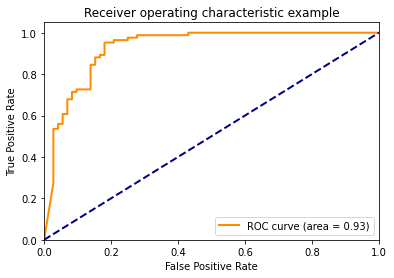

Epoch 1/30
39/39 [==============================] - 18s 454ms/step - loss: 4.2308 - AUC: 0.6821 - Precision: 0.6307 - TP: 234.0000 - FP: 137.0000 - TN: 263.0000 - FN: 145.0000 - acc: 0.5955
Epoch 2/30
39/39 [==============================] - 18s 452ms/step - loss: 3.2137 - AUC: 0.6375 - Precision: 0.5657 - TP: 168.0000 - FP: 129.0000 - TN: 199.0000 - FN: 127.0000 - acc: 0.5891
Epoch 3/30
39/39 [==============================] - 18s 450ms/step - loss: 1.8612 - AUC: 0.6667 - Precision: 0.5947 - TP: 179.0000 - FP: 122.0000 - TN: 206.0000 - FN: 116.0000 - acc: 0.6180
Epoch 4/30
39/39 [==============================] - 18s 450ms/step - loss: 1.0267 - AUC: 0.7279 - Precision: 0.6568 - TP: 222.0000 - FP: 116.0000 - TN: 212.0000 - FN: 73.0000 - acc: 0.6966
Epoch 5/30
39/39 [==============================] - 18s 450ms/step - loss: 1.1023 - AUC: 0.7789 - Precision: 0.7007 - TP: 213.0000 - FP: 91.0000 - TN: 237.0000 - FN: 82.0000 - acc: 0.7223
Epoch 6/30
39/39 [==============================] - 1

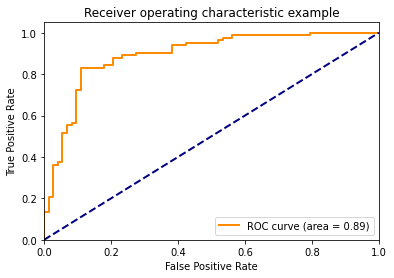

Epoch 1/30
39/39 [==============================] - 17s 449ms/step - loss: 4.2357 - AUC: 0.6032 - Precision: 0.5833 - TP: 224.0000 - FP: 160.0000 - TN: 231.0000 - FN: 164.0000 - acc: 0.5249
Epoch 2/30
39/39 [==============================] - 18s 449ms/step - loss: 2.7927 - AUC: 0.6664 - Precision: 0.6219 - TP: 199.0000 - FP: 121.0000 - TN: 197.0000 - FN: 106.0000 - acc: 0.6356
Epoch 3/30
39/39 [==============================] - 17s 447ms/step - loss: 1.4927 - AUC: 0.7249 - Precision: 0.6655 - TP: 197.0000 - FP: 99.0000 - TN: 219.0000 - FN: 108.0000 - acc: 0.6677
Epoch 4/30
39/39 [==============================] - 18s 452ms/step - loss: 1.5612 - AUC: 0.7092 - Precision: 0.6656 - TP: 205.0000 - FP: 103.0000 - TN: 215.0000 - FN: 100.0000 - acc: 0.6742
Epoch 5/30
39/39 [==============================] - 17s 448ms/step - loss: 1.6924 - AUC: 0.7557 - Precision: 0.7044 - TP: 224.0000 - FP: 94.0000 - TN: 224.0000 - FN: 81.0000 - acc: 0.7191
Epoch 6/30
39/39 [==============================] - 1

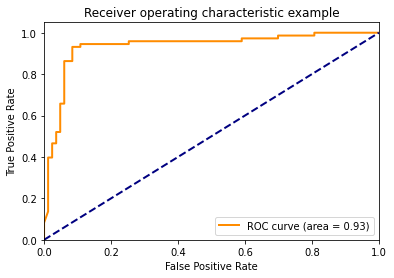

Epoch 1/30
39/39 [==============================] - 17s 445ms/step - loss: 3.7612 - AUC: 0.6620 - Precision: 0.5990 - TP: 242.0000 - FP: 162.0000 - TN: 230.0000 - FN: 145.0000 - acc: 0.5281
Epoch 2/30
39/39 [==============================] - 18s 453ms/step - loss: 1.8014 - AUC: 0.7261 - Precision: 0.6926 - TP: 214.0000 - FP: 95.0000 - TN: 214.0000 - FN: 100.0000 - acc: 0.6870
Epoch 3/30
39/39 [==============================] - 18s 452ms/step - loss: 1.4134 - AUC: 0.7250 - Precision: 0.6758 - TP: 198.0000 - FP: 95.0000 - TN: 214.0000 - FN: 116.0000 - acc: 0.6613
Epoch 4/30
39/39 [==============================] - 17s 448ms/step - loss: 1.2414 - AUC: 0.8174 - Precision: 0.7476 - TP: 237.0000 - FP: 80.0000 - TN: 229.0000 - FN: 77.0000 - acc: 0.7480
Epoch 5/30
39/39 [==============================] - 18s 450ms/step - loss: 1.0547 - AUC: 0.7916 - Precision: 0.7353 - TP: 225.0000 - FP: 81.0000 - TN: 228.0000 - FN: 89.0000 - acc: 0.7271
Epoch 6/30
39/39 [==============================] - 18s 

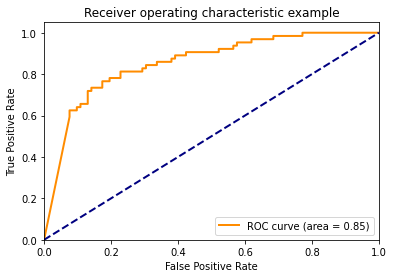

Epoch 1/30
39/39 [==============================] - 18s 452ms/step - loss: 4.3980 - AUC: 0.6527 - Precision: 0.5928 - TP: 230.0000 - FP: 158.0000 - TN: 254.0000 - FN: 138.0000 - acc: 0.5962
Epoch 2/30
39/39 [==============================] - 18s 454ms/step - loss: 1.6126 - AUC: 0.7284 - Precision: 0.6593 - TP: 209.0000 - FP: 108.0000 - TN: 212.0000 - FN: 95.0000 - acc: 0.6747
Epoch 3/30
39/39 [==============================] - 18s 452ms/step - loss: 1.6667 - AUC: 0.7198 - Precision: 0.6689 - TP: 202.0000 - FP: 100.0000 - TN: 220.0000 - FN: 102.0000 - acc: 0.6763
Epoch 4/30
39/39 [==============================] - 18s 454ms/step - loss: 2.1752 - AUC: 0.7372 - Precision: 0.6984 - TP: 213.0000 - FP: 92.0000 - TN: 228.0000 - FN: 91.0000 - acc: 0.7067
Epoch 5/30
39/39 [==============================] - 18s 451ms/step - loss: 1.7785 - AUC: 0.7573 - Precision: 0.7089 - TP: 207.0000 - FP: 85.0000 - TN: 235.0000 - FN: 97.0000 - acc: 0.7083
Epoch 6/30
39/39 [==============================] - 18s

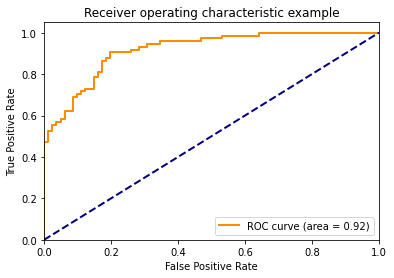

In [30]:
from sklearn.model_selection import KFold
from sklearn import metrics
y_trues = []
y_preds = []
AUC = tf.keras.metrics.AUC(name = 'AUC')
Precision = tf.keras.metrics.Precision(name = 'Precision')
TP = tf.keras.metrics.TruePositives(name = 'TP')
FP = tf.keras.metrics.FalsePositives(name = 'FP')
TN = tf.keras.metrics.TrueNegatives(name = 'TN')
FN = tf.keras.metrics.FalseNegatives(name = 'FN')
tps = 0
fps = 0
tns = 0
fns = 0
kf = KFold(n_splits=5,random_state=10, shuffle=True)
for train_index, test_index in kf.split(subjects):
    test = [subjects[i] for i in test_index]
    train = [subjects[i] for i in train_index]
    
    train_gen = SubjectGenerator(train,batch_size = 16,shuffle = True)
    test_gen = SubjectGenerator(test,batch_size=16)
    basemodel1 = base_line_model_1()
    basemodel1.compile(optimizer = tf.keras.optimizers.Adadelta(lr = 0.1,rho = 0.9),loss = 'binary_crossentropy',metrics = [AUC,Precision,TP,FP,TN,FN,'acc'])
    basemodel1.fit_generator(train_gen,epochs = 30 , verbose=1)
    y_true = test_gen.get_labels()
    y_pred = basemodel1.predict_generator(test_gen)
    y_trues.append(y_true)
    y_preds.append(y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    eva = basemodel1.evaluate_generator(test_gen)
    tp,fp,tn,fn = eva[3:7]
    tps += tp
    fps += fp
    tns += tn
    fns += fn

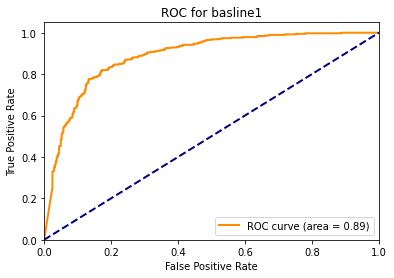

In [31]:
y_true = np.concatenate([y_trues[0],y_trues[1],y_trues[2],y_trues[3],y_trues[4]])
y_pred = np.concatenate([y_preds[0],y_preds[1],y_preds[2],y_preds[3],y_preds[4]])
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for basline1')
plt.legend(loc="lower right")
plt.show()

In [32]:
print('TPR :: {}'.format(tps/(tps+fns)))
print('TNR :: {}'.format(tns/(tns+fps)))
print('PPV :: {}'.format(tps/(tps+fps)))
print('ACC :: {}'.format((tps+tns)/(fps+fns+tps+tns)))

TPR :: 0.843915343915344
TNR :: 0.7930174563591023
PPV :: 0.7935323383084577
ACC :: 0.8177150192554558


In [69]:
basemodel1.save_weights("baseline1.h5")

In [17]:
def base_line_model_2():
    #baseline2 architecture
    input1 = Input(shape=(100,100,10,1))
    input2 = Input(shape=(50,50,5,1))

    #####
    ##first path
    #####

    p1 = MaxPool3D(pool_size=(2,2,2))(input1)

    conv1_1_1= Conv3D(32,(3,3,3),padding='same',activation=tf.nn.relu)(p1)
    bn1_1_1 = BatchNormalization()(conv1_1_1)


    conv1_1_2= Conv3D(32,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_1_1)
    bn1_1_2 = BatchNormalization()(conv1_1_2)


    p1_1 = MaxPool3D(pool_size=(2,2,1))(bn1_1_2)
    flat1_1 = Flatten()(p1_1)
    out1_1 = Dense(1,activation=tf.nn.sigmoid)(flat1_1)

    conv1_2_1= Conv3D(64,(3,3,3),padding='same',activation=tf.nn.relu)(p1_1)
    bn1_2_1 = BatchNormalization()(conv1_2_1)

    conv1_2_2= Conv3D(64,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_2_1)
    bn1_2_2 = BatchNormalization()(conv1_2_2)

    p1_2 = MaxPool3D(pool_size=(2,2,1))(bn1_2_2)
    flat1_2 = Flatten()(p1_2)
    out1_2 = Dense(1,activation=tf.nn.sigmoid)(flat1_2)


    conv1_3_1= Conv3D(128,(3,3,3),padding='same',activation=tf.nn.relu)(p1_2)
    bn1_3_1 = BatchNormalization()(conv1_3_1)

    conv1_3_2= Conv3D(128,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_3_1)
    bn1_3_2 = BatchNormalization()(conv1_3_2)

    p1_3 = MaxPool3D(pool_size=(2,2,1))(bn1_3_2)
    flat1_3 = Flatten()(p1_3)
    out1_3 = Dense(1,activation=tf.nn.sigmoid)(flat1_3)

    conv1_4_1= Conv3D(256,(3,3,3),padding='same',activation=tf.nn.relu)(p1_3)
    bn1_4_1 = BatchNormalization()(conv1_4_1)

    conv1_4_2= Conv3D(256,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_4_1)
    bn1_4_2 = BatchNormalization()(conv1_4_2)

    p1_4 = MaxPool3D(pool_size=(2,2,1))(bn1_4_2)
    flat1_4 = Flatten()(p1_4)
    out1_4 = Dense(1,activation=tf.nn.sigmoid)(flat1_4)


    conv1_5_1= Conv3D(512,(3,3,3),padding='same',activation=tf.nn.relu)(p1_4)
    bn1_5_1 = BatchNormalization()(conv1_5_1)

    conv1_5_2= Conv3D(512,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_5_1)
    bn1_5_2 = BatchNormalization()(conv1_5_2)



    #####
    ##second path
    #####


    conv2_1_1= Conv3D(32,(3,3,3),padding='same',activation=tf.nn.relu)(input2)
    bn2_1_1 = BatchNormalization()(conv2_1_1)

    conv2_1_2= Conv3D(32,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_1_1)
    bn2_1_2 = BatchNormalization()(conv2_1_2)

    p2_1 = MaxPool3D(pool_size=(2,2,1))(bn2_1_2)
    flat2_1 = Flatten()(p2_1)
    out2_1 = Dense(1,activation=tf.nn.sigmoid)(flat2_1)

    conv2_2_1= Conv3D(64,(3,3,3),padding='same',activation=tf.nn.relu)(p2_1)
    bn2_2_1 = BatchNormalization()(conv2_2_1)

    conv2_2_2= Conv3D(64,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_2_1)
    bn2_2_2 = BatchNormalization()(conv2_2_2)

    p2_2 = MaxPool3D(pool_size=(2,2,1))(bn2_2_2)
    flat2_2 = Flatten()(p2_2)
    out2_2 = Dense(1,activation=tf.nn.sigmoid)(flat2_2)


    conv2_3_1= Conv3D(128,(3,3,3),padding='same',activation=tf.nn.relu)(p2_2)
    bn2_3_1 = BatchNormalization()(conv2_3_1)

    conv2_3_2= Conv3D(128,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_3_1)
    bn2_3_2 = BatchNormalization()(conv2_3_2)

    p2_3 = MaxPool3D(pool_size=(2,2,1))(bn2_3_2)
    flat2_3 = Flatten()(p2_3)
    out2_3 = Dense(1,activation=tf.nn.sigmoid)(flat2_3)


    conv2_4_1= Conv3D(256,(3,3,3),padding='same',activation=tf.nn.relu)(p2_3)
    bn2_4_1 = BatchNormalization()(conv2_4_1)

    conv2_4_2= Conv3D(256,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_4_1)
    bn2_4_2 = BatchNormalization()(conv2_4_2)

    p2_4 = MaxPool3D(pool_size=(2,2,1))(bn2_4_2)
    flat2_4 = Flatten()(p2_4)
    out2_4 = Dense(1,activation=tf.nn.sigmoid)(flat2_4)


    conv2_5_1= Conv3D(512,(3,3,3),padding='same',activation=tf.nn.relu)(p2_4)
    bn2_5_1 = BatchNormalization()(conv2_5_1)

    conv2_5_2= Conv3D(512,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_5_1)
    bn2_5_2 = BatchNormalization()(conv2_5_2)

    concat = concatenate([bn2_5_2,bn1_5_2])
    features1 =  Flatten()(concat)
    features = concatenate([features1,flat1_1,flat1_2,flat1_3,flat1_4,flat2_1,flat2_2,flat2_3,flat2_4])

    ####
    ##concat
    ####


    main_out1 = Dense(1,activation=tf.nn.sigmoid,name='main')(features)
    model = tf.keras.models.Model(inputs = [input1,input2],
                                        outputs=[main_out1,out1_1,out1_2,out1_3,out1_4,out2_1,out2_2,out2_3,out2_4])
    return model

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
39/39 [==============================] - 18s 463ms/step - loss: 34.0016 - main_loss: 13.7022 - dense_loss: 5.0770 - dense_1_loss: 1.9958 - dense_2_loss: 1.3828 - dense_3_loss: 1.9809 - dense_4_loss: 5.2084 - dense_5_loss: 1.7950 - dense_6_loss: 1.2318 - dense_7_loss: 1.6276 - main_AUC: 0.7061 - main_Precision: 0.6770 - main_TP: 197.0000 - main_FP: 94.0000 - main_TN: 235.0000 - main_FN: 97.0000 - main_acc: 0.6934 - dense_AUC: 0.6405 - dense_Precision: 0.6084 - dense_TP: 174.0000 - dense_FP: 112.0000 - dense_TN: 217.0000 - dense_FN: 120.0000 - dense_acc: 0.6276 - dense_1_AUC: 0.6800 - dense_1_Precision: 0.6162 - dense_1_TP: 175.0000 - dense_1_FP: 109.0000 - dense_1_TN: 220.0000 - dense_1_FN: 119.0000 - dense_1_acc: 0.6340 - dense_2_AUC: 0.6655 - dense_2_Precision: 0.6189 - dense_2_TP: 177.0000 - dense_2_FP: 109.0000 - dense_2_TN: 220.0000 - dense_2_FN: 117.0000 - dense_2_acc: 0.6372 - dense_3_AUC: 0.62

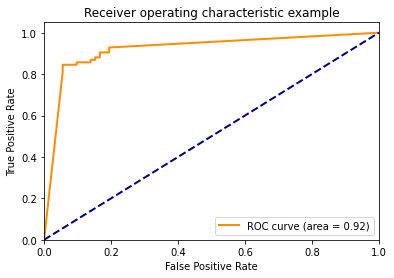

Instructions for updating:
Please use Model.evaluate, which supports generators.
Epoch 1/20
39/39 [==============================] - 18s 466ms/step - loss: 41.8453 - main_loss: 20.1214 - dense_8_loss: 5.2872 - dense_9_loss: 2.2610 - dense_10_loss: 1.6947 - dense_11_loss: 2.0314 - dense_12_loss: 4.7953 - dense_13_loss: 2.1947 - dense_14_loss: 1.7889 - dense_15_loss: 1.6706 - main_AUC: 0.6986 - main_Precision: 0.6757 - main_TP: 200.0000 - main_FP: 96.0000 - main_TN: 232.0000 - main_FN: 95.0000 - main_acc: 0.6934 - dense_8_AUC: 0.6628 - dense_8_Precision: 0.6208 - dense_8_TP: 185.0000 - dense_8_FP: 113.0000 - dense_8_TN: 215.0000 - dense_8_FN: 110.0000 - dense_8_acc: 0.6421 - dense_9_AUC: 0.6913 - dense_9_Precision: 0.6288 - dense_9_TP: 188.0000 - dense_9_FP: 111.0000 - dense_9_TN: 217.0000 - dense_9_FN: 107.0000 - dense_9_acc: 0.6501 - dense_10_AUC: 0.6262 - dense_10_Precision: 0.5777 - dense_10_TP: 171.0000 - dense_10_FP: 125.0000 - dense_10_TN: 203.0000 - dense_10_FN: 124.0000 - dense_

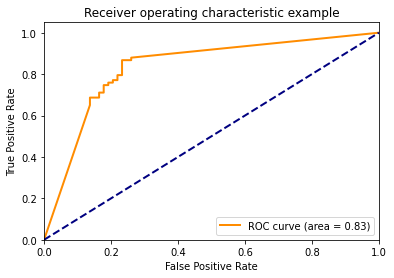

Epoch 1/20
39/39 [==============================] - 18s 466ms/step - loss: 41.9442 - main_loss: 20.4285 - dense_16_loss: 5.1215 - dense_17_loss: 2.9390 - dense_18_loss: 1.8115 - dense_19_loss: 1.5462 - dense_20_loss: 3.9426 - dense_21_loss: 2.8142 - dense_22_loss: 1.6693 - dense_23_loss: 1.6713 - main_AUC: 0.6883 - main_Precision: 0.6724 - main_TP: 197.0000 - main_FP: 96.0000 - main_TN: 222.0000 - main_FN: 108.0000 - main_acc: 0.6726 - dense_16_AUC: 0.6562 - dense_16_Precision: 0.6254 - dense_16_TP: 182.0000 - dense_16_FP: 109.0000 - dense_16_TN: 209.0000 - dense_16_FN: 123.0000 - dense_16_acc: 0.6276 - dense_17_AUC: 0.5889 - dense_17_Precision: 0.5773 - dense_17_TP: 168.0000 - dense_17_FP: 123.0000 - dense_17_TN: 195.0000 - dense_17_FN: 137.0000 - dense_17_acc: 0.5827 - dense_18_AUC: 0.5712 - dense_18_Precision: 0.5225 - dense_18_TP: 151.0000 - dense_18_FP: 138.0000 - dense_18_TN: 180.0000 - dense_18_FN: 154.0000 - dense_18_acc: 0.5313 - dense_19_AUC: 0.5526 - dense_19_Precision: 0.51

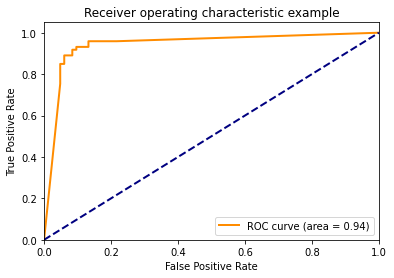

Epoch 1/20
39/39 [==============================] - 18s 469ms/step - loss: 40.5740 - main_loss: 18.1350 - dense_24_loss: 4.6703 - dense_25_loss: 3.0939 - dense_26_loss: 2.0183 - dense_27_loss: 1.8217 - dense_28_loss: 4.6466 - dense_29_loss: 2.8602 - dense_30_loss: 1.7391 - dense_31_loss: 1.5888 - main_AUC: 0.6849 - main_Precision: 0.6720 - main_TP: 209.0000 - main_FP: 102.0000 - main_TN: 207.0000 - main_FN: 105.0000 - main_acc: 0.6677 - dense_24_AUC: 0.6657 - dense_24_Precision: 0.6314 - dense_24_TP: 197.0000 - dense_24_FP: 115.0000 - dense_24_TN: 194.0000 - dense_24_FN: 117.0000 - dense_24_acc: 0.6276 - dense_25_AUC: 0.6404 - dense_25_Precision: 0.6038 - dense_25_TP: 192.0000 - dense_25_FP: 126.0000 - dense_25_TN: 183.0000 - dense_25_FN: 122.0000 - dense_25_acc: 0.6019 - dense_26_AUC: 0.6083 - dense_26_Precision: 0.5875 - dense_26_TP: 188.0000 - dense_26_FP: 132.0000 - dense_26_TN: 177.0000 - dense_26_FN: 126.0000 - dense_26_acc: 0.5859 - dense_27_AUC: 0.6117 - dense_27_Precision: 0.5

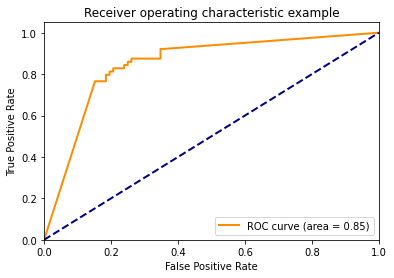

Epoch 1/20
39/39 [==============================] - 18s 473ms/step - loss: 40.9383 - main_loss: 17.0081 - dense_32_loss: 6.7731 - dense_33_loss: 2.3651 - dense_34_loss: 2.2671 - dense_35_loss: 2.0333 - dense_36_loss: 5.0558 - dense_37_loss: 2.0206 - dense_38_loss: 1.8865 - dense_39_loss: 1.5287 - main_AUC: 0.7250 - main_Precision: 0.6931 - main_TP: 210.0000 - main_FP: 93.0000 - main_TN: 227.0000 - main_FN: 94.0000 - main_acc: 0.7003 - dense_32_AUC: 0.6059 - dense_32_Precision: 0.5811 - dense_32_TP: 172.0000 - dense_32_FP: 124.0000 - dense_32_TN: 196.0000 - dense_32_FN: 132.0000 - dense_32_acc: 0.5897 - dense_33_AUC: 0.6791 - dense_33_Precision: 0.6242 - dense_33_TP: 191.0000 - dense_33_FP: 115.0000 - dense_33_TN: 205.0000 - dense_33_FN: 113.0000 - dense_33_acc: 0.6346 - dense_34_AUC: 0.6535 - dense_34_Precision: 0.5916 - dense_34_TP: 197.0000 - dense_34_FP: 136.0000 - dense_34_TN: 184.0000 - dense_34_FN: 107.0000 - dense_34_acc: 0.6106 - dense_35_AUC: 0.6109 - dense_35_Precision: 0.577

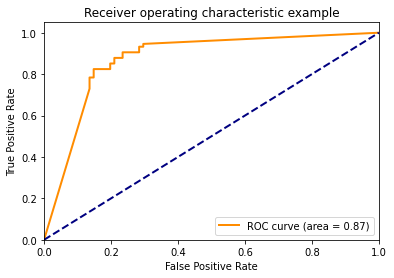

In [21]:
from sklearn.model_selection import KFold
from sklearn import metrics
y_trues = []
y_preds = []
AUC = tf.keras.metrics.AUC(name = 'AUC')
Precision = tf.keras.metrics.Precision(name = 'Precision')
TP = tf.keras.metrics.TruePositives(name = 'TP')
FP = tf.keras.metrics.FalsePositives(name = 'FP')
TN = tf.keras.metrics.TrueNegatives(name = 'TN')
FN = tf.keras.metrics.FalseNegatives(name = 'FN')
tps = 0
fps = 0
tns = 0
fns = 0
kf = KFold(n_splits=5,random_state=10, shuffle=True)
for train_index, test_index in kf.split(subjects):
    test = [subjects[i] for i in test_index]
    train = [subjects[i] for i in train_index]
    
    train_gen = SubjectGenerator(train,batch_size = 16,shuffle = True,MO=True)
    test_gen = SubjectGenerator(test,batch_size=16,MO=True)
    baselin2 = base_line_model_2()
    baselin2.compile(optimizer = tf.keras.optimizers.Adadelta(lr=0.1,rho=0.9),loss = 'binary_crossentropy',metrics = [AUC,Precision,TP,FP,TN,FN,'acc'])
    baselin2.fit_generator(train_gen,epochs = 30 , verbose=1)
    y_true = test_gen.get_labels()
    y_pred = baselin2.predict_generator(test_gen)
    y_trues.append(y_true)
    y_preds.append(y_pred[0])
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred[0])
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    eva = baselin2.evaluate_generator(test_gen)
    tp,fp,tn,fn = eva[12:16]
    tps += tp
    fps += fp
    tns += tn
    fns += fn
    
    

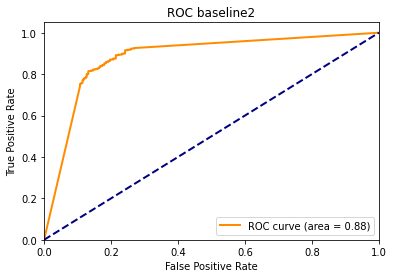

In [23]:
y_true = np.concatenate([y_trues[0],y_trues[1],y_trues[2],y_trues[3],y_trues[4]])
y_pred = np.concatenate([y_preds[0],y_preds[1],y_preds[2],y_preds[3],y_preds[4]])
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC baseline2')
plt.legend(loc="lower right")
plt.show()

In [24]:
print('TPR :: {}'.format(tps/(tps+fns)))
print('TNR :: {}'.format(tns/(tns+fps)))
print('PPV :: {}'.format(tps/(tps+fps)))
print('ACC :: {}'.format((tps+tns)/(fps+fns+tps+tns)))

TPR :: 0.7804232804232805
TNR :: 0.8753117206982544
PPV :: 0.855072463768116
ACC :: 0.8292682926829268


In [62]:
baseline2.save_weights("baseline2.h5")

In [19]:
#preparing DenseNet block
def densNetBlock(input_layer,feature_maps,len):
  out_layer = input_layer
  for i in range(len):
    Ctemp = Conv3D(feature_maps,(3,3,3),activation=tf.nn.relu,padding='same')(out_layer)
    Btemp = BatchNormalization()(Ctemp)
    out_layer = tf.keras.layers.concatenate([Btemp,out_layer])
  return out_layer

In [20]:
def base_line_model_3():
    #Dense3d model1
    input1 = Input(shape=(100,100,10,1))
    input2 = Input(shape=(50,50,5,1))

    #####
    ##first path
    #####

    p1 = MaxPool3D(pool_size=(2,2,2))(input1)
    DB1_1 = densNetBlock(p1,12,4)

    p1_1 = MaxPool3D(pool_size=(2,2,1))(DB1_1)
    DB1_2 = densNetBlock(p1_1,12,10)

    p1_2 = MaxPool3D(pool_size=(2,2,1))(DB1_2)
    DB1_3 = densNetBlock(p1_2,12,20)


    p1_3 = MaxPool3D(pool_size=(2,2,1))(DB1_3)
    DB1_4 = densNetBlock(p1_3,24,20)


    p1_4 = MaxPool3D(pool_size=(2,2,1))(DB1_4)
    DB1_5 = densNetBlock(p1_4,48,20)



    #####
    ##second path
    #####


    DB2_1 = densNetBlock(input2,12,4)

    p2_1 = MaxPool3D(pool_size=(2,2,1))(DB2_1)
    DB2_2 = densNetBlock(p2_1,12,10)

    p2_2 = MaxPool3D(pool_size=(2,2,1))(DB2_2)
    DB2_3 = densNetBlock(p2_2,12,20)


    p2_3 = MaxPool3D(pool_size=(2,2,1))(DB2_3)
    DB2_4 = densNetBlock(p2_3,24,20)


    p2_4 = MaxPool3D(pool_size=(2,2,1))(DB2_4)
    DB2_5 = densNetBlock(p2_4,48,20)



    ####
    ##concat
    ####

    concat = concatenate([DB1_5,DB2_5])
    features =  Flatten()(concat)
    main_out3 = Dense(1,activation=tf.nn.sigmoid)(features)
    model = tf.keras.models.Model(inputs = [input1,input2],
                                        outputs=[main_out3])
    return model

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
39/39 [==============================] - 28s 708ms/step - loss: 14.8592 - AUC: 0.6335 - Precision: 0.6034 - TP: 175.0000 - FP: 115.0000 - TN: 214.0000 - FN: 119.0000 - acc: 0.6244
Epoch 2/20
39/39 [==============================] - 25s 647ms/step - loss: 5.5568 - AUC: 0.7890 - Precision: 0.7442 - TP: 224.0000 - FP: 77.0000 - TN: 252.0000 - FN: 70.0000 - acc: 0.7640
Epoch 3/20
39/39 [==============================] - 25s 648ms/step - loss: 11.6491 - AUC: 0.7419 - Precision: 0.7250 - TP: 203.0000 - FP: 77.0000 - TN: 252.0000 - FN: 91.0000 - acc: 0.7303
Epoch 4/20
39/39 [==============================] - 25s 650ms/step - loss: 14.0592 - AUC: 0.7668 - Precision: 0.7336 - TP: 223.0000 - FP: 81.0000 - TN: 248.0000 - FN: 71.0000 - acc: 0.7560
Epoch 5/20
39/39 [==============================] - 25s 650ms/step - loss: 7.3901 - AUC: 0.8222 - Precision: 0.7986 - TP: 234.0000 - FP: 59.0000 - TN: 270.0000 - FN: 6

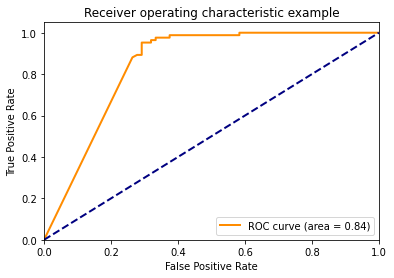

Instructions for updating:
Please use Model.evaluate, which supports generators.
Epoch 1/20
39/39 [==============================] - 25s 644ms/step - loss: 15.6344 - AUC: 0.6697 - Precision: 0.6377 - TP: 257.0000 - FP: 146.0000 - TN: 254.0000 - FN: 122.0000 - acc: 0.6116
Epoch 2/20
39/39 [==============================] - 25s 648ms/step - loss: 7.2342 - AUC: 0.7563 - Precision: 0.7292 - TP: 210.0000 - FP: 78.0000 - TN: 250.0000 - FN: 85.0000 - acc: 0.7384
Epoch 3/20
39/39 [==============================] - 25s 650ms/step - loss: 6.6065 - AUC: 0.8086 - Precision: 0.7891 - TP: 232.0000 - FP: 62.0000 - TN: 266.0000 - FN: 63.0000 - acc: 0.7994
Epoch 4/20
39/39 [==============================] - 25s 651ms/step - loss: 4.6045 - AUC: 0.8344 - Precision: 0.8131 - TP: 235.0000 - FP: 54.0000 - TN: 274.0000 - FN: 60.0000 - acc: 0.8170
Epoch 5/20
39/39 [==============================] - 25s 650ms/step - loss: 6.5704 - AUC: 0.8313 - Precision: 0.8102 - TP: 239.0000 - FP: 56.0000 - TN: 272.0000 - FN

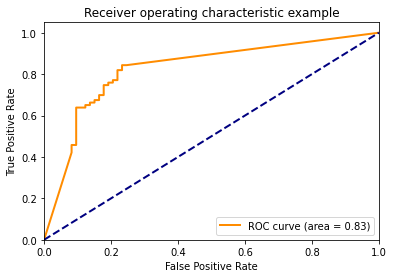

Epoch 1/20
39/39 [==============================] - 25s 645ms/step - loss: 30.3785 - AUC: 0.6011 - Precision: 0.6051 - TP: 213.0000 - FP: 139.0000 - TN: 252.0000 - FN: 175.0000 - acc: 0.5698
Epoch 2/20
39/39 [==============================] - 25s 648ms/step - loss: 11.2118 - AUC: 0.7160 - Precision: 0.6984 - TP: 220.0000 - FP: 95.0000 - TN: 223.0000 - FN: 85.0000 - acc: 0.7111
Epoch 3/20
39/39 [==============================] - 25s 650ms/step - loss: 6.1698 - AUC: 0.7966 - Precision: 0.7763 - TP: 229.0000 - FP: 66.0000 - TN: 252.0000 - FN: 76.0000 - acc: 0.7721
Epoch 4/20
39/39 [==============================] - 25s 651ms/step - loss: 5.3971 - AUC: 0.7989 - Precision: 0.7702 - TP: 238.0000 - FP: 71.0000 - TN: 247.0000 - FN: 67.0000 - acc: 0.7785
Epoch 5/20
39/39 [==============================] - 25s 650ms/step - loss: 5.1017 - AUC: 0.8229 - Precision: 0.7993 - TP: 243.0000 - FP: 61.0000 - TN: 257.0000 - FN: 62.0000 - acc: 0.8026
Epoch 6/20
39/39 [==============================] - 25s 

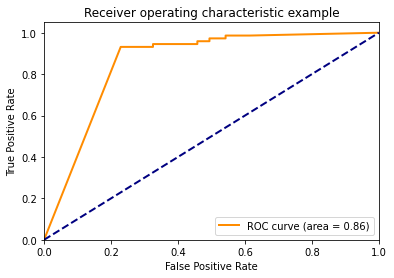

Epoch 1/20
39/39 [==============================] - 25s 646ms/step - loss: 18.3180 - AUC: 0.6781 - Precision: 0.6571 - TP: 276.0000 - FP: 144.0000 - TN: 248.0000 - FN: 111.0000 - acc: 0.6421
Epoch 2/20
39/39 [==============================] - 25s 650ms/step - loss: 7.2437 - AUC: 0.7831 - Precision: 0.7785 - TP: 239.0000 - FP: 68.0000 - TN: 241.0000 - FN: 75.0000 - acc: 0.7705
Epoch 3/20
39/39 [==============================] - 25s 652ms/step - loss: 6.0403 - AUC: 0.7817 - Precision: 0.7587 - TP: 239.0000 - FP: 76.0000 - TN: 233.0000 - FN: 75.0000 - acc: 0.7576
Epoch 4/20
39/39 [==============================] - 25s 653ms/step - loss: 5.6105 - AUC: 0.8205 - Precision: 0.7925 - TP: 252.0000 - FP: 66.0000 - TN: 243.0000 - FN: 62.0000 - acc: 0.7945
Epoch 5/20
39/39 [==============================] - 25s 653ms/step - loss: 6.5625 - AUC: 0.7933 - Precision: 0.7890 - TP: 243.0000 - FP: 65.0000 - TN: 244.0000 - FN: 71.0000 - acc: 0.7817
Epoch 6/20
39/39 [==============================] - 25s 6

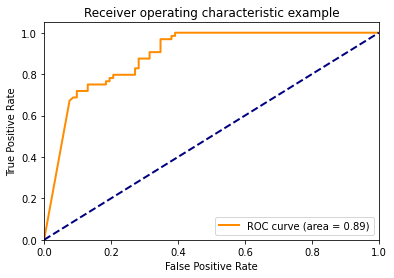

Epoch 1/20
39/39 [==============================] - 25s 647ms/step - loss: 21.9271 - AUC: 0.6566 - Precision: 0.6240 - TP: 229.0000 - FP: 138.0000 - TN: 274.0000 - FN: 139.0000 - acc: 0.6074
Epoch 2/20
39/39 [==============================] - 25s 651ms/step - loss: 6.7871 - AUC: 0.7611 - Precision: 0.7203 - TP: 224.0000 - FP: 87.0000 - TN: 233.0000 - FN: 80.0000 - acc: 0.7324
Epoch 3/20
39/39 [==============================] - 25s 652ms/step - loss: 10.3062 - AUC: 0.7787 - Precision: 0.7549 - TP: 231.0000 - FP: 75.0000 - TN: 245.0000 - FN: 73.0000 - acc: 0.7628
Epoch 4/20
39/39 [==============================] - 25s 653ms/step - loss: 7.9898 - AUC: 0.8060 - Precision: 0.7724 - TP: 241.0000 - FP: 71.0000 - TN: 249.0000 - FN: 63.0000 - acc: 0.7853
Epoch 5/20
39/39 [==============================] - 25s 653ms/step - loss: 7.9251 - AUC: 0.8128 - Precision: 0.8047 - TP: 239.0000 - FP: 58.0000 - TN: 262.0000 - FN: 65.0000 - acc: 0.8029
Epoch 6/20
39/39 [==============================] - 25s 

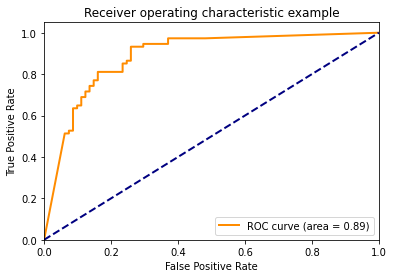

In [21]:
from sklearn.model_selection import KFold
from sklearn import metrics
y_trues = []
y_preds = []
AUC = tf.keras.metrics.AUC(name = 'AUC')
Precision = tf.keras.metrics.Precision(name = 'Precision')
TP = tf.keras.metrics.TruePositives(name = 'TP')
FP = tf.keras.metrics.FalsePositives(name = 'FP')
TN = tf.keras.metrics.TrueNegatives(name = 'TN')
FN = tf.keras.metrics.FalseNegatives(name = 'FN')
tps = 0
fps = 0
tns = 0
fns = 0
kf = KFold(n_splits=5,random_state=10, shuffle=True)
for train_index, test_index in kf.split(subjects):
    test = [subjects[i] for i in test_index]
    train = [subjects[i] for i in train_index]
    
    train_gen = SubjectGenerator(train,batch_size = 16,shuffle = True)
    test_gen = SubjectGenerator(test,batch_size=16)
    basemodel1 = base_line_model_3()
    basemodel1.compile(optimizer = tf.keras.optimizers.Adadelta(lr = 0.1,rho = 0.9),loss = 'binary_crossentropy',metrics = [AUC,Precision,TP,FP,TN,FN,'acc'])
    basemodel1.fit_generator(train_gen,epochs = 30 , verbose=1)
    y_true = test_gen.get_labels()
    y_pred = basemodel1.predict_generator(test_gen)
    y_trues.append(y_true)
    y_preds.append(y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    eva = basemodel1.evaluate_generator(test_gen)
    tp,fp,tn,fn = eva[3:7]
    tps += tp
    fps += fp
    tns += tn
    fns += fn

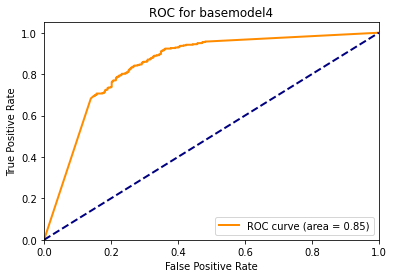

In [23]:
y_true = np.concatenate([y_trues[0],y_trues[1],y_trues[2],y_trues[3],y_trues[4]])
y_pred = np.concatenate([y_preds[0],y_preds[1],y_preds[2],y_preds[3],y_preds[4]])
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for basemodel4')
plt.legend(loc="lower right")
plt.show()

In [24]:
print('TPR :: {}'.format(tps/(tps+fns)))
print('TNR :: {}'.format(tns/(tns+fps)))
print('PPV :: {}'.format(tps/(tps+fps)))
print('ACC :: {}'.format((tps+tns)/(fps+fns+tps+tns)))

TPR :: 0.7671957671957672
TNR :: 0.7955112219451371
PPV :: 0.7795698924731183
ACC :: 0.7817715019255456


In [68]:
baseline3.save_weights("baseline3.h5")

In [77]:
test = baseline3.evaluate_generator(test_gen)
tp,fp,tn,fn = test[3:7]
print('TPR :: {}'.format(tp/(tp+fn)))
print('TNR :: {}'.format(tn/(tn+fp)))
print('PPV :: {}'.format(test[2]))
print('ACC :: {}'.format(test[7]))

TPR :: 0.8615384615384616
TNR :: 0.7444444444444445
PPV :: 0.7088607549667358
ACC :: 0.7935484051704407


In [20]:
#preparing DenseNet block
def densNetBlock(input_layer,feature_maps,len):
  out_layer = input_layer
  for i in range(len):
    Ctemp = Conv3D(feature_maps,(3,3,3),activation=tf.nn.relu,padding='same')(out_layer)
    Btemp = BatchNormalization()(Ctemp)
    out_layer = tf.keras.layers.concatenate([Btemp,out_layer])
  return out_layer

In [21]:
def base_line_model_4():
    #Dense3d model2
    input1 = Input(shape=(100,100,10,1))
    input2 = Input(shape=(50,50,5,1))

    #####
    ##first path
    #####

    p1 = MaxPool3D(pool_size=(2,2,2))(input1)
    DB1_1 = densNetBlock(p1,12,4)

    p1_1 = MaxPool3D(pool_size=(2,2,1))(DB1_1)
    flat1_1 = Flatten()(p1_1)
    out1_1 = Dense(1,activation = tf.nn.sigmoid)(flat1_1)
    DB1_2 = densNetBlock(p1_1,12,10)

    p1_2 = MaxPool3D(pool_size=(2,2,1))(DB1_2)
    flat1_2 = Flatten()(p1_2)
    out1_2 = Dense(1,activation = tf.nn.sigmoid)(flat1_2)
    DB1_3 = densNetBlock(p1_2,12,20)


    p1_3 = MaxPool3D(pool_size=(2,2,1))(DB1_3)
    flat1_3 = Flatten()(p1_3)
    out1_3 = Dense(1,activation = tf.nn.sigmoid)(flat1_3)
    DB1_4 = densNetBlock(p1_3,24,20)


    p1_4 = MaxPool3D(pool_size=(2,2,1))(DB1_4)
    flat1_4 = Flatten()(p1_4)
    out1_4 = Dense(1,activation = tf.nn.sigmoid)(flat1_4)
    DB1_5 = densNetBlock(p1_4,48,20)



    #####
    ##second path
    #####


    DB2_1 = densNetBlock(input2,12,4)

    p2_1 = MaxPool3D(pool_size=(2,2,1))(DB2_1)
    flat2_1 = Flatten()(p2_1)
    out2_1 = Dense(1,activation = tf.nn.sigmoid)(flat2_1)
    DB2_2 = densNetBlock(p2_1,12,10)

    p2_2 = MaxPool3D(pool_size=(2,2,1))(DB2_2)
    flat2_2 = Flatten()(p2_2)
    out2_2 = Dense(1,activation = tf.nn.sigmoid)(flat2_2)
    DB2_3 = densNetBlock(p2_2,12,20)


    p2_3 = MaxPool3D(pool_size=(2,2,1))(DB2_3)
    flat2_3 = Flatten()(p2_3)
    out2_3 = Dense(1,activation = tf.nn.sigmoid)(flat2_3)
    DB2_4 = densNetBlock(p2_3,24,20)


    p2_4 = MaxPool3D(pool_size=(2,2,1))(DB2_4)
    flat2_4 = Flatten()(p2_4)
    out2_4 = Dense(1,activation = tf.nn.sigmoid)(flat2_4)
    DB2_5 = densNetBlock(p2_4,48,20)



    ####
    ##concat
    ####

    concat = concatenate([DB1_5,DB2_5])
    features1 =  Flatten()(concat)
    features = concatenate([features1,flat1_1,flat1_2,flat1_3,flat1_4,flat2_1,flat2_2,flat2_3,flat2_4])
    main_out4 = Dense(1,activation=tf.nn.sigmoid,name='main')(features)
    base_model4 = tf.keras.models.Model(inputs = [input1,input2],
                                        outputs=[main_out4,out1_1,out1_2,out1_3,out1_4,out2_1,out2_2,out2_3,out2_4])
    
    return base_model4

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
39/39 [==============================] - 28s 726ms/step - loss: 1253.9620 - main_loss: 654.0914 - dense_loss: 272.7669 - dense_1_loss: 94.6939 - dense_2_loss: 27.7384 - dense_3_loss: 11.4107 - dense_4_loss: 118.7910 - dense_5_loss: 47.3329 - dense_6_loss: 19.7294 - dense_7_loss: 7.4076 - main_AUC: 0.6050 - main_Precision: 0.5816 - main_TP: 171.0000 - main_FP: 123.0000 - main_TN: 206.0000 - main_FN: 123.0000 - main_acc: 0.6051 - dense_AUC: 0.5674 - dense_Precision: 0.5452 - dense_TP: 163.0000 - dense_FP: 136.0000 - dense_TN: 193.0000 - dense_FN: 131.0000 - dense_acc: 0.5714 - dense_1_AUC: 0.5118 - dense_1_Precision: 0.4882 - dense_1_TP: 145.0000 - dense_1_FP: 152.0000 - dense_1_TN: 177.0000 - dense_1_FN: 149.0000 - dense_1_acc: 0.5169 - dense_2_AUC: 0.5656 - dense_2_Precision: 0.5372 - dense_2_TP: 159.0000 - dense_2_FP: 137.0000 - dense_2_TN: 192.0000 - dense_2_FN: 135.0000 - dense_2_acc: 0.5634 - den

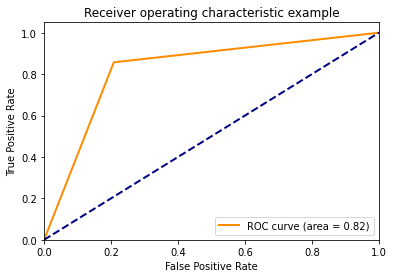

Instructions for updating:
Please use Model.evaluate, which supports generators.
Epoch 1/30
39/39 [==============================] - 26s 662ms/step - loss: 1117.2661 - main_loss: 512.6304 - dense_8_loss: 266.8736 - dense_9_loss: 52.3049 - dense_10_loss: 28.0631 - dense_11_loss: 12.1075 - dense_12_loss: 166.3622 - dense_13_loss: 40.4725 - dense_14_loss: 26.0056 - dense_15_loss: 12.4462 - main_AUC: 0.6220 - main_Precision: 0.6020 - main_TP: 177.0000 - main_FP: 117.0000 - main_TN: 211.0000 - main_FN: 118.0000 - main_acc: 0.6228 - dense_8_AUC: 0.5302 - dense_8_Precision: 0.5068 - dense_8_TP: 150.0000 - dense_8_FP: 146.0000 - dense_8_TN: 182.0000 - dense_8_FN: 145.0000 - dense_8_acc: 0.5329 - dense_9_AUC: 0.5726 - dense_9_Precision: 0.5500 - dense_9_TP: 165.0000 - dense_9_FP: 135.0000 - dense_9_TN: 193.0000 - dense_9_FN: 130.0000 - dense_9_acc: 0.5746 - dense_10_AUC: 0.5133 - dense_10_Precision: 0.4881 - dense_10_TP: 144.0000 - dense_10_FP: 151.0000 - dense_10_TN: 177.0000 - dense_10_FN: 15

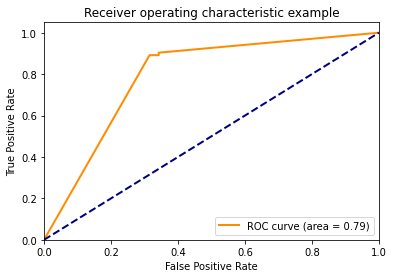

Epoch 1/30
39/39 [==============================] - 26s 663ms/step - loss: 1197.2118 - main_loss: 659.1702 - dense_16_loss: 219.9197 - dense_17_loss: 50.2874 - dense_18_loss: 26.2141 - dense_19_loss: 12.5110 - dense_20_loss: 158.6547 - dense_21_loss: 46.3256 - dense_22_loss: 15.9750 - dense_23_loss: 8.1541 - main_AUC: 0.6118 - main_Precision: 0.6046 - main_TP: 185.0000 - main_FP: 121.0000 - main_TN: 197.0000 - main_FN: 120.0000 - main_acc: 0.6132 - dense_16_AUC: 0.5153 - dense_16_Precision: 0.5049 - dense_16_TP: 155.0000 - dense_16_FP: 152.0000 - dense_16_TN: 166.0000 - dense_16_FN: 150.0000 - dense_16_acc: 0.5152 - dense_17_AUC: 0.5846 - dense_17_Precision: 0.5779 - dense_17_TP: 178.0000 - dense_17_FP: 130.0000 - dense_17_TN: 188.0000 - dense_17_FN: 127.0000 - dense_17_acc: 0.5875 - dense_18_AUC: 0.5516 - dense_18_Precision: 0.5400 - dense_18_TP: 162.0000 - dense_18_FP: 138.0000 - dense_18_TN: 180.0000 - dense_18_FN: 143.0000 - dense_18_acc: 0.5490 - dense_19_AUC: 0.5757 - dense_19_Pr

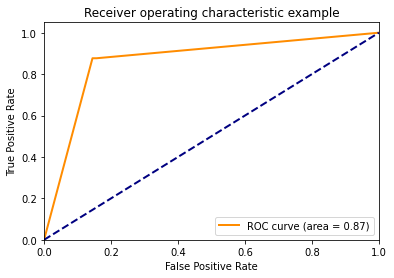

Epoch 1/30
39/39 [==============================] - 26s 662ms/step - loss: 1316.0026 - main_loss: 714.7564 - dense_24_loss: 238.1676 - dense_25_loss: 52.6720 - dense_26_loss: 27.2015 - dense_27_loss: 10.8326 - dense_28_loss: 181.9665 - dense_29_loss: 60.4253 - dense_30_loss: 22.5657 - dense_31_loss: 7.4150 - main_AUC: 0.6024 - main_Precision: 0.6019 - main_TP: 195.0000 - main_FP: 129.0000 - main_TN: 180.0000 - main_FN: 119.0000 - main_acc: 0.6019 - dense_24_AUC: 0.5426 - dense_24_Precision: 0.5452 - dense_24_TP: 175.0000 - dense_24_FP: 146.0000 - dense_24_TN: 163.0000 - dense_24_FN: 139.0000 - dense_24_acc: 0.5425 - dense_25_AUC: 0.5683 - dense_25_Precision: 0.5671 - dense_25_TP: 186.0000 - dense_25_FP: 142.0000 - dense_25_TN: 167.0000 - dense_25_FN: 128.0000 - dense_25_acc: 0.5666 - dense_26_AUC: 0.5455 - dense_26_Precision: 0.5387 - dense_26_TP: 174.0000 - dense_26_FP: 149.0000 - dense_26_TN: 160.0000 - dense_26_FN: 140.0000 - dense_26_acc: 0.5361 - dense_27_AUC: 0.4946 - dense_27_Pr

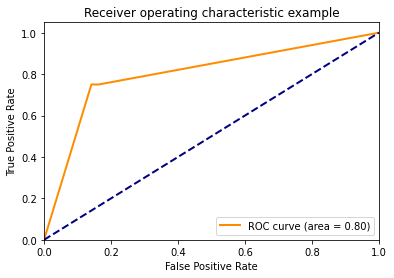

Epoch 1/30
39/39 [==============================] - 26s 663ms/step - loss: 1001.9245 - main_loss: 476.7550 - dense_32_loss: 218.4466 - dense_33_loss: 62.4113 - dense_34_loss: 18.9581 - dense_35_loss: 10.9553 - dense_36_loss: 156.8327 - dense_37_loss: 36.7491 - dense_38_loss: 15.2041 - dense_39_loss: 5.6122 - main_AUC: 0.6294 - main_Precision: 0.6132 - main_TP: 195.0000 - main_FP: 123.0000 - main_TN: 197.0000 - main_FN: 109.0000 - main_acc: 0.6282 - dense_32_AUC: 0.5810 - dense_32_Precision: 0.5691 - dense_32_TP: 177.0000 - dense_32_FP: 134.0000 - dense_32_TN: 186.0000 - dense_32_FN: 127.0000 - dense_32_acc: 0.5817 - dense_33_AUC: 0.5428 - dense_33_Precision: 0.5314 - dense_33_TP: 169.0000 - dense_33_FP: 149.0000 - dense_33_TN: 171.0000 - dense_33_FN: 135.0000 - dense_33_acc: 0.5449 - dense_34_AUC: 0.5367 - dense_34_Precision: 0.5230 - dense_34_TP: 159.0000 - dense_34_FP: 145.0000 - dense_34_TN: 175.0000 - dense_34_FN: 145.0000 - dense_34_acc: 0.5353 - dense_35_AUC: 0.5671 - dense_35_Pr

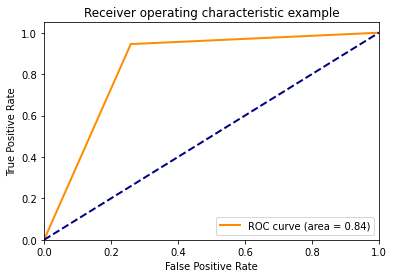

In [22]:
from sklearn.model_selection import KFold
from sklearn import metrics
y_trues = []
y_preds = []
AUC = tf.keras.metrics.AUC(name = 'AUC')
Precision = tf.keras.metrics.Precision(name = 'Precision')
TP = tf.keras.metrics.TruePositives(name = 'TP')
FP = tf.keras.metrics.FalsePositives(name = 'FP')
TN = tf.keras.metrics.TrueNegatives(name = 'TN')
FN = tf.keras.metrics.FalseNegatives(name = 'FN')
tps = 0
fps = 0
tns = 0
fns = 0
kf = KFold(n_splits=5,random_state=10, shuffle=True)
for train_index, test_index in kf.split(subjects):
    test = [subjects[i] for i in test_index]
    train = [subjects[i] for i in train_index]
    
    train_gen = SubjectGenerator(train,batch_size = 16,shuffle = True,MO=True)
    test_gen = SubjectGenerator(test,batch_size=16,MO=True)
    baselin2 = base_line_model_4()
    baselin2.compile(optimizer = tf.keras.optimizers.Adadelta(lr = 0.1,rho = 0.9),loss = 'binary_crossentropy',metrics = [AUC,Precision,TP,FP,TN,FN,'acc'])
    baselin2.fit_generator(train_gen,epochs = 30 , verbose=1)
    y_true = test_gen.get_labels()
    y_pred = baselin2.predict_generator(test_gen)
    y_trues.append(y_true)
    y_preds.append(y_pred[0])
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred[0])
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    eva = baselin2.evaluate_generator(test_gen)
    tp,fp,tn,fn = eva[12:16]
    tps += tp
    fps += fp
    tns += tn
    fns += fn

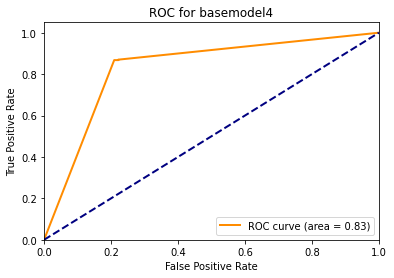

In [23]:
y_true = np.concatenate([y_trues[0],y_trues[1],y_trues[2],y_trues[3],y_trues[4]])
y_pred = np.concatenate([y_preds[0],y_preds[1],y_preds[2],y_preds[3],y_preds[4]])
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for basemodel4')
plt.legend(loc="lower right")
plt.show()

In [24]:
print('TPR :: {}'.format(tps/(tps+fns)))
print('TNR :: {}'.format(tns/(tns+fps)))
print('PPV :: {}'.format(tps/(tps+fps)))
print('ACC :: {}'.format((tps+tns)/(fps+fns+tps+tns)))

TPR :: 0.8677248677248677
TNR :: 0.7905236907730673
PPV :: 0.7961165048543689
ACC :: 0.82798459563543


In [23]:
baseline4.save_weights("baseline4.h5")

In [34]:
def Simple_EfficientNet():
  #baseline1 architecture
  input1 = Input(shape=(100,100,10,1))
  input2 = Input(shape=(50,50,5,1))

  #####
  ##first path
  #####

  p1 = MaxPool3D(pool_size=(2,2,2))(input1)

  conv1_1_1= Conv3D(39,(3,3,3),padding='same',activation=tf.nn.relu)(p1)
  bn1_1_1 = BatchNormalization()(conv1_1_1)

  conv1_1_2= Conv3D(39,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_1_1)
  bn1_1_2 = BatchNormalization()(conv1_1_2)

  conv1_1_3= Conv3D(39,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_1_2)
  bn1_1_3 = BatchNormalization()(conv1_1_3)
  # ------------------------------------------
  p1_1 = MaxPool3D(pool_size=(2,2,1))(bn1_1_3)

  conv1_2_1= Conv3D(77,(3,3,3),padding='same',activation=tf.nn.relu)(p1_1)
  bn1_2_1 = BatchNormalization()(conv1_2_1)

  conv1_2_2= Conv3D(77,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_2_1)
  bn1_2_2 = BatchNormalization()(conv1_2_2)

  conv1_2_3= Conv3D(77,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_2_2)
  bn1_2_3 = BatchNormalization()(conv1_2_3)

  # ------------------------------------------

  p1_2 = MaxPool3D(pool_size=(2,2,1))(bn1_2_3)


  conv1_3_1= Conv3D(154,(3,3,3),padding='same',activation=tf.nn.relu)(p1_2)
  bn1_3_1 = BatchNormalization()(conv1_3_1)

  conv1_3_2= Conv3D(154,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_3_1)
  bn1_3_2 = BatchNormalization()(conv1_3_2)

  conv1_3_3= Conv3D(154,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_3_2)
  bn1_3_3 = BatchNormalization()(conv1_3_3)


  # ------------------------------------------
  p1_3 = MaxPool3D(pool_size=(2,2,1))(bn1_3_3)


  conv1_4_1= Conv3D(309,(3,3,3),padding='same',activation=tf.nn.relu)(p1_3)
  bn1_4_1 = BatchNormalization()(conv1_4_1)

  conv1_4_2= Conv3D(309,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_4_1)
  bn1_4_2 = BatchNormalization()(conv1_4_2)


  conv1_4_3= Conv3D(309,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_4_2)
  bn1_4_3 = BatchNormalization()(conv1_4_3)


  # ------------------------------------------

  p1_4 = MaxPool3D(pool_size=(2,2,1))(bn1_4_3)


  conv1_5_1= Conv3D(620,(3,3,3),padding='same',activation=tf.nn.relu)(p1_4)
  bn1_5_1 = BatchNormalization()(conv1_5_1)

  conv1_5_2= Conv3D(620,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_5_1)
  bn1_5_2 = BatchNormalization()(conv1_5_2)

  conv1_5_3= Conv3D(620,(3,3,3),padding='same',activation=tf.nn.relu)(bn1_5_2)
  bn1_5_3 = BatchNormalization()(conv1_5_3)

  # ------------------------------------------

  #####
  ##second path
  #####


  conv2_1_1= Conv3D(39,(3,3,3),padding='same',activation=tf.nn.relu)(input2)
  bn2_1_1 = BatchNormalization()(conv2_1_1)

  conv2_1_2= Conv3D(39,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_1_1)
  bn2_1_2 = BatchNormalization()(conv2_1_2)

  conv2_1_3= Conv3D(39,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_1_2)
  bn2_1_3 = BatchNormalization()(conv2_1_3)

  # ------------------------------------------

  p2_1 = MaxPool3D(pool_size=(2,2,1))(bn2_1_3)

  conv2_2_1= Conv3D(77,(3,3,3),padding='same',activation=tf.nn.relu)(p2_1)
  bn2_2_1 = BatchNormalization()(conv2_2_1)

  conv2_2_2= Conv3D(77,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_2_1)
  bn2_2_2 = BatchNormalization()(conv2_2_2)

  conv2_2_3= Conv3D(77,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_2_2)
  bn2_2_3 = BatchNormalization()(conv2_2_3)

  # ------------------------------------------
  p2_2 = MaxPool3D(pool_size=(2,2,1))(bn2_2_3)


  conv2_3_1= Conv3D(154,(3,3,3),padding='same',activation=tf.nn.relu)(p2_2)
  bn2_3_1 = BatchNormalization()(conv2_3_1)

  conv2_3_2= Conv3D(154,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_3_1)
  bn2_3_2 = BatchNormalization()(conv2_3_2)

  conv2_3_3= Conv3D(154,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_3_2)
  bn2_3_3 = BatchNormalization()(conv2_3_3)

  # ------------------------------------------
  p2_3 = MaxPool3D(pool_size=(2,2,1))(bn2_3_3)


  conv2_4_1= Conv3D(309,(3,3,3),padding='same',activation=tf.nn.relu)(p2_3)
  bn2_4_1 = BatchNormalization()(conv2_4_1)

  conv2_4_2= Conv3D(309,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_4_1)
  bn2_4_2 = BatchNormalization()(conv2_4_2)

  conv2_4_3= Conv3D(309,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_4_2)
  bn2_4_3 = BatchNormalization()(conv2_4_3)
  # ------------------------------------------
  p2_4 = MaxPool3D(pool_size=(2,2,1))(bn2_4_3)


  conv2_5_1= Conv3D(620,(3,3,3),padding='same',activation=tf.nn.relu)(p2_4)
  bn2_5_1 = BatchNormalization()(conv2_5_1)

  conv2_5_2= Conv3D(620,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_5_1)
  bn2_5_2 = BatchNormalization()(conv2_5_2)

  conv2_5_3= Conv3D(620,(3,3,3),padding='same',activation=tf.nn.relu)(bn2_5_2)
  bn2_5_3 = BatchNormalization()(conv2_5_3)
  # ------------------------------------------


  ####
  ##concat
  ####

  concat = concatenate([bn2_5_3,bn1_5_3])
  features =  Flatten()(concat)
  main_out = Dense(1,activation=tf.nn.sigmoid)(features)
  model = tf.keras.models.Model([input1,input2],[main_out])
  model.compile(optimizer = tf.keras.optimizers.Adadelta(lr = 0.1,rho = 0.9),loss = 'binary_crossentropy',metrics = ['acc'])
  return model

In [45]:
efficient1.save_weights("efficient1.h5")

In [42]:
outp = efficient1.predict_generator(test_gen)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
39/39 [==============================] - 18s 461ms/step - loss: 3.8554 - AUC: 0.6616 - Precision: 0.6136 - TP: 181.0000 - FP: 114.0000 - TN: 215.0000 - FN: 113.0000 - acc: 0.6356
Epoch 2/80
39/39 [==============================] - 18s 458ms/step - loss: 0.9182 - AUC: 0.8644 - Precision: 0.7793 - TP: 226.0000 - FP: 64.0000 - TN: 265.0000 - FN: 68.0000 - acc: 0.7881
Epoch 3/80
39/39 [==============================] - 18s 457ms/step - loss: 0.9670 - AUC: 0.8709 - Precision: 0.8108 - TP: 240.0000 - FP: 56.0000 - TN: 273.0000 - FN: 54.0000 - acc: 0.8234
Epoch 4/80
39/39 [==============================] - 18s 453ms/step - loss: 0.5087 - AUC: 0.9359 - Precision: 0.8724 - TP: 253.0000 - FP: 37.0000 - TN: 292.0000 - FN: 41.0000 - acc: 0.8748
Epoch 5/80
39/39 [==============================] - 18s 454ms/step - loss: 0.4188 - AUC: 0.9485 - Precision: 0.8986 - TP: 266.0000 - FP: 30.0000 - TN: 299.0000 - FN: 28.0

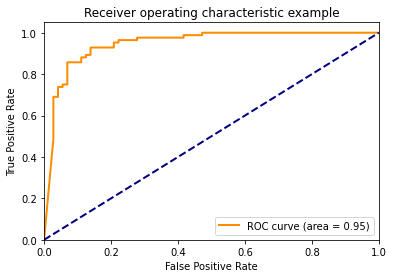

Instructions for updating:
Please use Model.evaluate, which supports generators.
Epoch 1/80
39/39 [==============================] - 18s 458ms/step - loss: 3.4054 - AUC: 0.7536 - Precision: 0.7124 - TP: 265.0000 - FP: 107.0000 - TN: 293.0000 - FN: 114.0000 - acc: 0.6790
Epoch 2/80
39/39 [==============================] - 18s 455ms/step - loss: 1.2628 - AUC: 0.8551 - Precision: 0.7700 - TP: 231.0000 - FP: 69.0000 - TN: 259.0000 - FN: 64.0000 - acc: 0.7865
Epoch 3/80
39/39 [==============================] - 18s 456ms/step - loss: 0.7555 - AUC: 0.9038 - Precision: 0.8255 - TP: 246.0000 - FP: 52.0000 - TN: 276.0000 - FN: 49.0000 - acc: 0.8379
Epoch 4/80
39/39 [==============================] - 18s 454ms/step - loss: 0.6441 - AUC: 0.9165 - Precision: 0.8606 - TP: 247.0000 - FP: 40.0000 - TN: 288.0000 - FN: 48.0000 - acc: 0.8587
Epoch 5/80
39/39 [==============================] - 18s 453ms/step - loss: 0.3172 - AUC: 0.9589 - Precision: 0.8973 - TP: 262.0000 - FP: 30.0000 - TN: 298.0000 - FN:

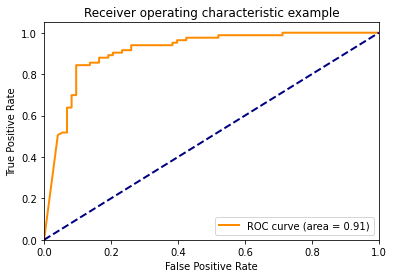

Epoch 1/80
39/39 [==============================] - 18s 457ms/step - loss: 3.9054 - AUC: 0.7335 - Precision: 0.6979 - TP: 268.0000 - FP: 116.0000 - TN: 275.0000 - FN: 120.0000 - acc: 0.6581
Epoch 2/80
39/39 [==============================] - 18s 454ms/step - loss: 1.4238 - AUC: 0.8199 - Precision: 0.7460 - TP: 232.0000 - FP: 79.0000 - TN: 239.0000 - FN: 73.0000 - acc: 0.7560
Epoch 3/80
39/39 [==============================] - 18s 455ms/step - loss: 0.8163 - AUC: 0.9001 - Precision: 0.8251 - TP: 250.0000 - FP: 53.0000 - TN: 265.0000 - FN: 55.0000 - acc: 0.8266
Epoch 4/80
39/39 [==============================] - 18s 456ms/step - loss: 0.5669 - AUC: 0.9260 - Precision: 0.8474 - TP: 261.0000 - FP: 47.0000 - TN: 271.0000 - FN: 44.0000 - acc: 0.8539
Epoch 5/80
39/39 [==============================] - 18s 457ms/step - loss: 0.4917 - AUC: 0.9363 - Precision: 0.8730 - TP: 268.0000 - FP: 39.0000 - TN: 279.0000 - FN: 37.0000 - acc: 0.8780
Epoch 6/80
39/39 [==============================] - 18s 45

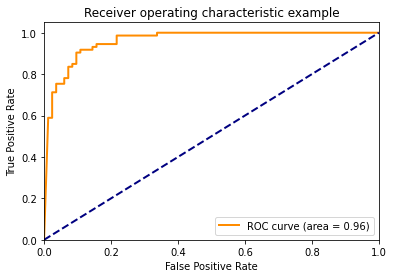

Epoch 1/80
39/39 [==============================] - 18s 460ms/step - loss: 3.6126 - AUC: 0.7469 - Precision: 0.6904 - TP: 272.0000 - FP: 122.0000 - TN: 270.0000 - FN: 115.0000 - acc: 0.6437
Epoch 2/80
39/39 [==============================] - 18s 453ms/step - loss: 1.3218 - AUC: 0.8282 - Precision: 0.7660 - TP: 239.0000 - FP: 73.0000 - TN: 236.0000 - FN: 75.0000 - acc: 0.7624
Epoch 3/80
39/39 [==============================] - 18s 459ms/step - loss: 0.5080 - AUC: 0.9230 - Precision: 0.8549 - TP: 271.0000 - FP: 46.0000 - TN: 263.0000 - FN: 43.0000 - acc: 0.8571
Epoch 4/80
39/39 [==============================] - 18s 459ms/step - loss: 0.6981 - AUC: 0.9085 - Precision: 0.8423 - TP: 267.0000 - FP: 50.0000 - TN: 259.0000 - FN: 47.0000 - acc: 0.8443
Epoch 5/80
39/39 [==============================] - 18s 457ms/step - loss: 0.4332 - AUC: 0.9373 - Precision: 0.8726 - TP: 274.0000 - FP: 40.0000 - TN: 269.0000 - FN: 40.0000 - acc: 0.8716
Epoch 6/80
39/39 [==============================] - 18s 45

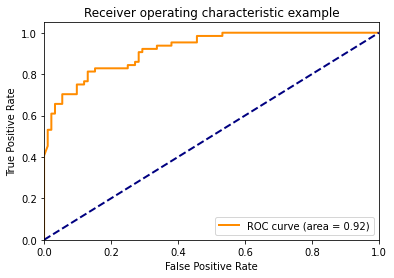

Epoch 1/80
39/39 [==============================] - 18s 456ms/step - loss: 4.1285 - AUC: 0.7258 - Precision: 0.6649 - TP: 254.0000 - FP: 128.0000 - TN: 284.0000 - FN: 114.0000 - acc: 0.6619
Epoch 2/80
39/39 [==============================] - 18s 455ms/step - loss: 1.2287 - AUC: 0.8532 - Precision: 0.7898 - TP: 233.0000 - FP: 62.0000 - TN: 258.0000 - FN: 71.0000 - acc: 0.7869
Epoch 3/80
39/39 [==============================] - 18s 457ms/step - loss: 0.5859 - AUC: 0.9125 - Precision: 0.8371 - TP: 257.0000 - FP: 50.0000 - TN: 270.0000 - FN: 47.0000 - acc: 0.8446
Epoch 4/80
39/39 [==============================] - 18s 458ms/step - loss: 0.5152 - AUC: 0.9272 - Precision: 0.8418 - TP: 250.0000 - FP: 47.0000 - TN: 273.0000 - FN: 54.0000 - acc: 0.8381
Epoch 5/80
39/39 [==============================] - 18s 458ms/step - loss: 0.4174 - AUC: 0.9397 - Precision: 0.8511 - TP: 263.0000 - FP: 46.0000 - TN: 274.0000 - FN: 41.0000 - acc: 0.8606
Epoch 6/80
39/39 [==============================] - 18s 46

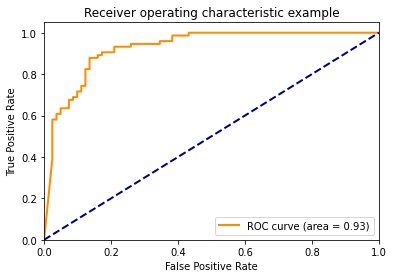

In [22]:
from sklearn.model_selection import KFold
from sklearn import metrics
y_trues = []
y_preds = []
AUC = tf.keras.metrics.AUC(name = 'AUC')
Precision = tf.keras.metrics.Precision(name = 'Precision')
TP = tf.keras.metrics.TruePositives(name = 'TP')
FP = tf.keras.metrics.FalsePositives(name = 'FP')
TN = tf.keras.metrics.TrueNegatives(name = 'TN')
FN = tf.keras.metrics.FalseNegatives(name = 'FN')
tps = 0
fps = 0
tns = 0
fns = 0
kf = KFold(n_splits=5,random_state=10, shuffle=True)
for train_index, test_index in kf.split(subjects):
    test = [subjects[i] for i in test_index]
    train = [subjects[i] for i in train_index]
    
    train_gen = SubjectGenerator(train,batch_size = 16,shuffle = True)
    test_gen = SubjectGenerator(test,batch_size=16)
    efficient1 = Simple_EfficientNet()
    efficient1.compile(optimizer = tf.keras.optimizers.Adadelta(lr = 0.1,rho = 0.9),loss = 'binary_crossentropy',metrics = [AUC,Precision,TP,FP,TN,FN,'acc'])
    efficient1.fit_generator(train_gen,epochs = 40 , verbose=1)
    y_true = test_gen.get_labels()
    y_pred = efficient1.predict_generator(test_gen)
    y_trues.append(y_true)
    y_preds.append(y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    eva = efficient1.evaluate_generator(test_gen)
    tp,fp,tn,fn = eva[3:7]
    tps += tp
    fps += fp
    tns += tn
    fns += fn

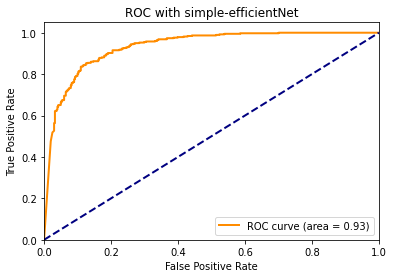

In [ ]:
y_true = np.concatenate([y_trues[0],y_trues[1],y_trues[2],y_trues[3],y_trues[4]])
y_pred = np.concatenate([y_preds[0],y_preds[1],y_preds[2],y_preds[3],y_preds[4]])
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with simple-efficientNet')
plt.legend(loc="lower right")
plt.show()

In [24]:
print('TPR :: {}'.format(tps/(tps+fns)))
print('TNR :: {}'.format(tns/(tns+fps)))
print('PPV :: {}'.format(tps/(tps+fps)))
print('ACC :: {}'.format((tps+tns)/(fps+fns+tps+tns)))

TPR :: 0.8624338624338624
TNR :: 0.8503740648379052
PPV :: 0.844559585492228
ACC :: 0.8562259306803595


In [27]:
efficient1.metrics_names

['loss', 'AUC', 'Precision', 'TP', 'FP', 'TN', 'FN', 'acc']

In [23]:
from tensorflow.keras.layers import *

def Leaky_EfficientNet():
  #baseline1 architecture
  input1 = Input(shape=(100,100,10,1))
  input2 = Input(shape=(50,50,5,1))
  Alpha = 0.4
  #####
  ##first path
  #####

  p1 = MaxPool3D(pool_size=(2,2,2))(input1)

  conv1_1_1= Conv3D(39,(3,3,3),padding='same')(p1)
  lk = LeakyReLU(alpha=Alpha)(conv1_1_1)
  bn1_1_1 = BatchNormalization()(lk)

  conv1_1_2= Conv3D(39,(3,3,3),padding='same')(bn1_1_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_1_2)
  bn1_1_2 = BatchNormalization()(lk)

  conv1_1_3= Conv3D(39,(3,3,3),padding='same')(bn1_1_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_1_3)
  bn1_1_3 = BatchNormalization()(lk)
  # ------------------------------------------
  p1_1 = MaxPool3D(pool_size=(2,2,1))(bn1_1_3)

  conv1_2_1= Conv3D(77,(3,3,3),padding='same')(p1_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_2_1)
  bn1_2_1 = BatchNormalization()(lk)

  conv1_2_2= Conv3D(77,(3,3,3),padding='same')(bn1_2_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_2_2)
  bn1_2_2 = BatchNormalization()(lk)

  conv1_2_3= Conv3D(77,(3,3,3),padding='same')(bn1_2_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_2_3)
  bn1_2_3 = BatchNormalization()(lk)

  # ------------------------------------------

  p1_2 = MaxPool3D(pool_size=(2,2,1))(bn1_2_3)


  conv1_3_1= Conv3D(154,(3,3,3),padding='same')(p1_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_3_1)
  bn1_3_1 = BatchNormalization()(lk)

  conv1_3_2= Conv3D(154,(3,3,3),padding='same')(bn1_3_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_3_2)
  bn1_3_2 = BatchNormalization()(lk)

  conv1_3_3= Conv3D(154,(3,3,3),padding='same')(bn1_3_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_3_3)
  bn1_3_3 = BatchNormalization()(lk)


  # ------------------------------------------
  p1_3 = MaxPool3D(pool_size=(2,2,1))(bn1_3_3)


  conv1_4_1= Conv3D(309,(3,3,3),padding='same')(p1_3)
  lk = LeakyReLU(alpha=Alpha)(conv1_4_1)
  bn1_4_1 = BatchNormalization()(lk)

  conv1_4_2= Conv3D(309,(3,3,3),padding='same')(bn1_4_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_4_2)
  bn1_4_2 = BatchNormalization()(lk)


  conv1_4_3= Conv3D(309,(3,3,3),padding='same')(bn1_4_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_4_3)
  bn1_4_3 = BatchNormalization()(lk)


  # ------------------------------------------

  p1_4 = MaxPool3D(pool_size=(2,2,1))(bn1_4_3)


  conv1_5_1= Conv3D(620,(3,3,3),padding='same')(p1_4)
  lk = LeakyReLU(alpha=Alpha)(conv1_5_1)
  bn1_5_1 = BatchNormalization()(lk)

  conv1_5_2= Conv3D(620,(3,3,3),padding='same')(bn1_5_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_5_2)
  bn1_5_2 = BatchNormalization()(lk)

  conv1_5_3= Conv3D(620,(3,3,3),padding='same')(bn1_5_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_5_3)
  bn1_5_3 = BatchNormalization()(lk)

  # ------------------------------------------

  #####
  ##second path
  #####


  conv2_1_1= Conv3D(39,(3,3,3),padding='same')(input2)
  lk = LeakyReLU(alpha=Alpha)(conv2_1_1)
  bn2_1_1 = BatchNormalization()(lk)

  conv2_1_2= Conv3D(39,(3,3,3),padding='same')(bn2_1_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_1_2)
  bn2_1_2 = BatchNormalization()(lk)

  conv2_1_3= Conv3D(39,(3,3,3),padding='same')(bn2_1_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_1_3)
  bn2_1_3 = BatchNormalization()(lk)

  # ------------------------------------------

  p2_1 = MaxPool3D(pool_size=(2,2,1))(bn2_1_3)

  conv2_2_1= Conv3D(77,(3,3,3),padding='same')(p2_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_2_1)
  bn2_2_1 = BatchNormalization()(lk)

  conv2_2_2= Conv3D(77,(3,3,3),padding='same')(bn2_2_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_2_2)
  bn2_2_2 = BatchNormalization()(lk)

  conv2_2_3= Conv3D(77,(3,3,3),padding='same')(bn2_2_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_2_3)
  bn2_2_3 = BatchNormalization()(lk)

  # ------------------------------------------
  p2_2 = MaxPool3D(pool_size=(2,2,1))(bn2_2_3)


  conv2_3_1= Conv3D(154,(3,3,3),padding='same')(p2_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_3_1)
  bn2_3_1 = BatchNormalization()(lk)

  conv2_3_2= Conv3D(154,(3,3,3),padding='same')(bn2_3_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_3_2)
  bn2_3_2 = BatchNormalization()(lk)

  conv2_3_3= Conv3D(154,(3,3,3),padding='same')(bn2_3_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_3_3)
  bn2_3_3 = BatchNormalization()(lk)

  # ------------------------------------------
  p2_3 = MaxPool3D(pool_size=(2,2,1))(bn2_3_3)


  conv2_4_1= Conv3D(309,(3,3,3),padding='same')(p2_3)
  lk = LeakyReLU(alpha=Alpha)(conv2_4_1)
  bn2_4_1 = BatchNormalization()(lk)

  conv2_4_2= Conv3D(309,(3,3,3),padding='same')(bn2_4_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_4_2)
  bn2_4_2 = BatchNormalization()(lk)

  conv2_4_3= Conv3D(309,(3,3,3),padding='same')(bn2_4_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_4_3)
  bn2_4_3 = BatchNormalization()(lk)
  # ------------------------------------------
  p2_4 = MaxPool3D(pool_size=(2,2,1))(bn2_4_3)


  conv2_5_1= Conv3D(620,(3,3,3),padding='same')(p2_4)
  lk = LeakyReLU(alpha=Alpha)(conv2_5_1)
  bn2_5_1 = BatchNormalization()(lk)

  conv2_5_2= Conv3D(620,(3,3,3),padding='same')(bn2_5_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_5_2)
  bn2_5_2 = BatchNormalization()(lk)

  conv2_5_3= Conv3D(620,(3,3,3),padding='same')(bn2_5_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_5_3)
  bn2_5_3 = BatchNormalization()(lk)
  # ------------------------------------------


  ####
  ##concat
  ####

  concat = concatenate([bn2_5_3,bn1_5_3])
  features =  Flatten()(concat)
  main_out = Dense(1,activation=tf.nn.sigmoid)(features)
  model = tf.keras.models.Model([input1,input2],[main_out])
  return model

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
39/39 [==============================] - 18s 460ms/step - loss: 4.5285 - AUC: 0.6632 - Precision: 0.6318 - TP: 187.0000 - FP: 109.0000 - TN: 220.0000 - FN: 107.0000 - acc: 0.6533
Epoch 2/80
39/39 [==============================] - 18s 454ms/step - loss: 1.2711 - AUC: 0.7929 - Precision: 0.7047 - TP: 210.0000 - FP: 88.0000 - TN: 241.0000 - FN: 84.0000 - acc: 0.7239
Epoch 3/80
39/39 [==============================] - 18s 458ms/step - loss: 0.6902 - AUC: 0.9000 - Precision: 0.8276 - TP: 240.0000 - FP: 50.0000 - TN: 279.0000 - FN: 54.0000 - acc: 0.8331
Epoch 4/80
39/39 [==============================] - 18s 453ms/step - loss: 0.5082 - AUC: 0.9353 - Precision: 0.8797 - TP: 256.0000 - FP: 35.0000 - TN: 294.0000 - FN: 38.0000 - acc: 0.8828
Epoch 5/80
39/39 [==============================] - 18s 462ms/step - loss: 0.1658 - AUC: 0.9838 - Precision: 0.9360 - TP: 278.0000 - FP: 19.0000 - TN: 310.0000 - FN: 16.0

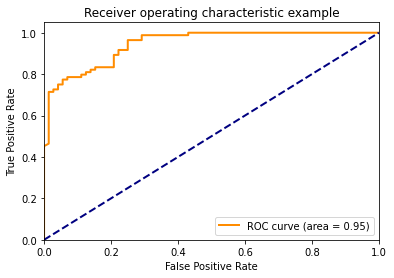

Instructions for updating:
Please use Model.evaluate, which supports generators.
Epoch 1/80
39/39 [==============================] - 18s 453ms/step - loss: 4.5906 - AUC: 0.7378 - Precision: 0.6772 - TP: 258.0000 - FP: 123.0000 - TN: 277.0000 - FN: 121.0000 - acc: 0.6533
Epoch 2/80
39/39 [==============================] - 18s 455ms/step - loss: 1.0516 - AUC: 0.8506 - Precision: 0.7835 - TP: 228.0000 - FP: 63.0000 - TN: 265.0000 - FN: 67.0000 - acc: 0.7913
Epoch 3/80
39/39 [==============================] - 18s 454ms/step - loss: 0.6936 - AUC: 0.8925 - Precision: 0.8191 - TP: 240.0000 - FP: 53.0000 - TN: 275.0000 - FN: 55.0000 - acc: 0.8266
Epoch 4/80
39/39 [==============================] - 18s 460ms/step - loss: 0.4618 - AUC: 0.9392 - Precision: 0.8707 - TP: 256.0000 - FP: 38.0000 - TN: 290.0000 - FN: 39.0000 - acc: 0.8764
Epoch 5/80
39/39 [==============================] - 18s 457ms/step - loss: 0.4196 - AUC: 0.9475 - Precision: 0.8973 - TP: 262.0000 - FP: 30.0000 - TN: 298.0000 - FN:

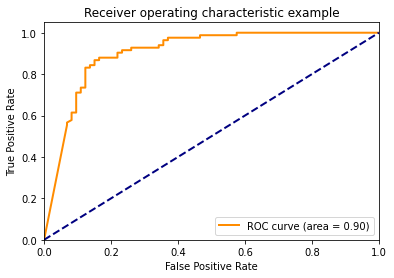

Epoch 1/80
39/39 [==============================] - 18s 455ms/step - loss: 4.6504 - AUC: 0.7373 - Precision: 0.6933 - TP: 269.0000 - FP: 119.0000 - TN: 272.0000 - FN: 119.0000 - acc: 0.6549
Epoch 2/80
39/39 [==============================] - 18s 453ms/step - loss: 1.1195 - AUC: 0.8334 - Precision: 0.7690 - TP: 233.0000 - FP: 70.0000 - TN: 248.0000 - FN: 72.0000 - acc: 0.7721
Epoch 3/80
39/39 [==============================] - 18s 456ms/step - loss: 0.7752 - AUC: 0.8809 - Precision: 0.8121 - TP: 242.0000 - FP: 56.0000 - TN: 262.0000 - FN: 63.0000 - acc: 0.8090
Epoch 4/80
39/39 [==============================] - 18s 453ms/step - loss: 0.5677 - AUC: 0.9099 - Precision: 0.8479 - TP: 262.0000 - FP: 47.0000 - TN: 271.0000 - FN: 43.0000 - acc: 0.8555
Epoch 5/80
39/39 [==============================] - 18s 456ms/step - loss: 0.4329 - AUC: 0.9421 - Precision: 0.8904 - TP: 268.0000 - FP: 33.0000 - TN: 285.0000 - FN: 37.0000 - acc: 0.8876
Epoch 6/80
39/39 [==============================] - 18s 45

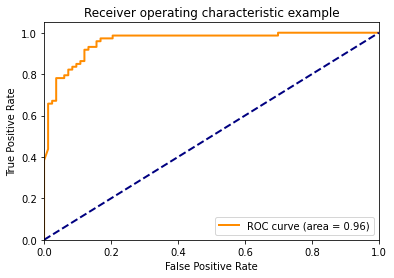

Epoch 1/80
39/39 [==============================] - 18s 454ms/step - loss: 4.3558 - AUC: 0.7428 - Precision: 0.7114 - TP: 281.0000 - FP: 114.0000 - TN: 278.0000 - FN: 106.0000 - acc: 0.6742
Epoch 2/80
39/39 [==============================] - 18s 452ms/step - loss: 1.1116 - AUC: 0.8391 - Precision: 0.8065 - TP: 250.0000 - FP: 60.0000 - TN: 249.0000 - FN: 64.0000 - acc: 0.8010
Epoch 3/80
39/39 [==============================] - 18s 454ms/step - loss: 0.8684 - AUC: 0.8864 - Precision: 0.7943 - TP: 251.0000 - FP: 65.0000 - TN: 244.0000 - FN: 63.0000 - acc: 0.7945
Epoch 4/80
39/39 [==============================] - 18s 458ms/step - loss: 0.5250 - AUC: 0.9195 - Precision: 0.8522 - TP: 271.0000 - FP: 47.0000 - TN: 262.0000 - FN: 43.0000 - acc: 0.8555
Epoch 5/80
39/39 [==============================] - 18s 453ms/step - loss: 0.4364 - AUC: 0.9373 - Precision: 0.8679 - TP: 276.0000 - FP: 42.0000 - TN: 267.0000 - FN: 38.0000 - acc: 0.8716
Epoch 6/80
39/39 [==============================] - 18s 45

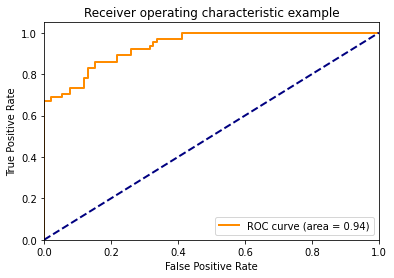

Epoch 1/80
39/39 [==============================] - 18s 455ms/step - loss: 4.6613 - AUC: 0.7212 - Precision: 0.6868 - TP: 261.0000 - FP: 119.0000 - TN: 293.0000 - FN: 107.0000 - acc: 0.6763
Epoch 2/80
39/39 [==============================] - 18s 454ms/step - loss: 1.1976 - AUC: 0.8201 - Precision: 0.7605 - TP: 235.0000 - FP: 74.0000 - TN: 246.0000 - FN: 69.0000 - acc: 0.7708
Epoch 3/80
39/39 [==============================] - 18s 452ms/step - loss: 0.8771 - AUC: 0.8665 - Precision: 0.7980 - TP: 245.0000 - FP: 62.0000 - TN: 258.0000 - FN: 59.0000 - acc: 0.8061
Epoch 4/80
39/39 [==============================] - 18s 454ms/step - loss: 0.5038 - AUC: 0.9229 - Precision: 0.8349 - TP: 263.0000 - FP: 52.0000 - TN: 268.0000 - FN: 41.0000 - acc: 0.8510
Epoch 5/80
39/39 [==============================] - 18s 451ms/step - loss: 0.5239 - AUC: 0.9312 - Precision: 0.8642 - TP: 261.0000 - FP: 41.0000 - TN: 279.0000 - FN: 43.0000 - acc: 0.8654
Epoch 6/80
39/39 [==============================] - 18s 45

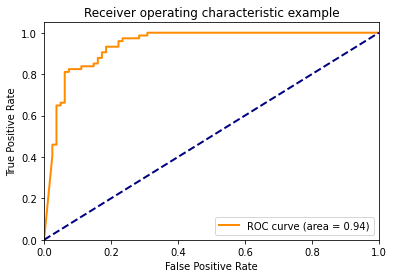

In [20]:
from sklearn.model_selection import KFold
from sklearn import metrics
y_trues = []
y_preds = []
AUC = tf.keras.metrics.AUC(name = 'AUC')
Precision = tf.keras.metrics.Precision(name = 'Precision')
TP = tf.keras.metrics.TruePositives(name = 'TP')
FP = tf.keras.metrics.FalsePositives(name = 'FP')
TN = tf.keras.metrics.TrueNegatives(name = 'TN')
FN = tf.keras.metrics.FalseNegatives(name = 'FN')
tps = 0
fps = 0
tns = 0
fns = 0
kf = KFold(n_splits=5,random_state=10, shuffle=True)
for train_index, test_index in kf.split(subjects):
    test = [subjects[i] for i in test_index]
    train = [subjects[i] for i in train_index]
    
    train_gen = SubjectGenerator(train,batch_size = 16,shuffle = True)
    test_gen = SubjectGenerator(test,batch_size=16)
    efficient2 = Leaky_EfficientNet()
    efficient2.compile(optimizer = tf.keras.optimizers.Adadelta(lr = 0.1,rho = 0.9),loss = 'binary_crossentropy',metrics = [AUC,Precision,TP,FP,TN,FN,'acc'])
    efficient2.fit_generator(train_gen,epochs = 40 , verbose=1)
    y_true = test_gen.get_labels()
    y_pred = efficient2.predict_generator(test_gen)
    y_trues.append(y_true)
    y_preds.append(y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    eva = efficient2.evaluate_generator(test_gen)
    tp,fp,tn,fn = eva[3:7]
    tps += tp
    fps += fp
    tns += tn
    fns += fn
    
    

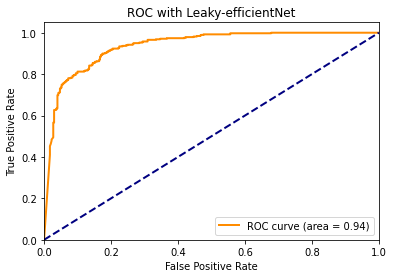

In [23]:
y_true = np.concatenate([y_trues[0],y_trues[1],y_trues[2],y_trues[3],y_trues[4]])
y_pred = np.concatenate([y_preds[0],y_preds[1],y_preds[2],y_preds[3],y_preds[4]])
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with Leaky-efficientNet')
plt.legend(loc="lower right")
plt.show()

In [22]:
print('TPR :: {}'.format(tps/(tps+fns)))
print('TNR :: {}'.format(tns/(tns+fps)))
print('PPV :: {}'.format(tps/(tps+fps)))
print('ACC :: {}'.format((tps+tns)/(fps+fns+tps+tns)))

TPR :: 0.8703703703703703
TNR :: 0.8354114713216958
PPV :: 0.8329113924050633
ACC :: 0.8523748395378691


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0
 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0
 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1
 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0
 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1
 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0
 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
39/39 [==============================] - 18s 461ms/step - loss: 4.0126 - AUC: 0.6972 - Precision: 0.6333 - TP: 190.0000 - FP: 110.0000 - TN: 219.0000 - FN: 104.0000 - acc: 0.6565
Epoch 2/80
39/39 [==============================] - 18s 454ms/step - loss: 1.0227 - AUC: 0.8294 - Precision: 0.7609 - TP: 226.0000 - FP: 71.0000 - TN: 258.0000 - FN: 68.0000 - acc: 0.7769
Epoch 3/80
39/39 [==============================] - 18s 455ms/step - loss: 0.9678 - AUC: 0.8387 - Precision: 0.7601 - TP: 225.0000 - FP: 71.0000 - TN: 258.0000 - FN: 69.0000 - acc: 0.7753
Epoch 4/80
39/39 [==============================] - 18s 454ms/step - loss: 0.5606 - AUC: 0.9090 - Precision: 0.8249 - TP: 245.0000 - FP: 52.0000 - TN: 277.0000 - FN: 49.0000 - acc: 0.8379
Epoch 5/80
39/39 [==============================] - 18s 454ms/step - loss: 0.3493 - AUC: 0.9561 - Precision: 0.8841 - TP: 267.0000 - FP: 35.0000 - TN: 294.0000 - FN: 27.0

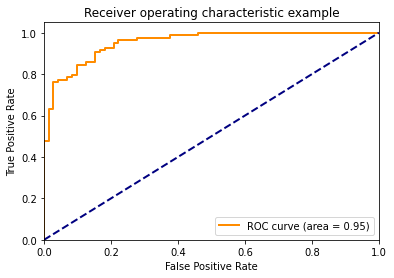

Instructions for updating:
Please use Model.evaluate, which supports generators.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1
 1 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0
 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0
 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1
 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0
 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0
 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 

Epoch 1/80
39/39 [==============================] - 18s 456ms/step - loss: 4.5279 - AUC: 0.7524 - Precision: 0.6961 - TP: 268.0000 - FP: 117.0000 - TN: 283.0000 - FN: 111.0000 - acc: 0.6693
Epoch 2/80
39/39 [==============================] - 18s 455ms/step - loss: 1.1755 - AUC: 0.8564 - Precision: 0.7723 - TP: 234.0000 - FP: 69.0000 - TN: 259.0000 - FN: 61.0000 - acc: 0.7913
Epoch 3/80
39/39 [==============================] - 18s 453ms/step - loss: 0.6837 - AUC: 0.9013 - Precision: 0.8333 - TP: 245.0000 - FP: 49.0000 - TN: 279.0000 - FN: 50.0000 - acc: 0.8411
Epoch 4/80
39/39 [==============================] - 18s 455ms/step - loss: 0.5084 - AUC: 0.9209 - Precision: 0.8439 - TP: 254.0000 - FP: 47.0000 - TN: 281.0000 - FN: 41.0000 - acc: 0.8587
Epoch 5/80
39/39 [==============================] - 18s 455ms/step - loss: 0.2312 - AUC: 0.9757 - Precision: 0.9094 - TP: 271.0000 - FP: 27.0000 - TN: 301.0000 - FN: 24.0000 - acc: 0.9181
Epoch 6/80
39/39 [==============================] - 18s 45

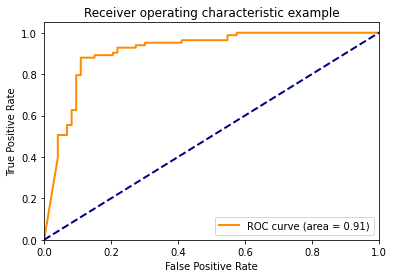

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1
 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1
 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1
 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1
 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0
 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 

Epoch 1/80
39/39 [==============================] - 18s 452ms/step - loss: 4.5451 - AUC: 0.7146 - Precision: 0.6945 - TP: 266.0000 - FP: 117.0000 - TN: 274.0000 - FN: 122.0000 - acc: 0.6533
Epoch 2/80
39/39 [==============================] - 18s 450ms/step - loss: 1.0710 - AUC: 0.8290 - Precision: 0.7540 - TP: 233.0000 - FP: 76.0000 - TN: 242.0000 - FN: 72.0000 - acc: 0.7624
Epoch 3/80
39/39 [==============================] - 18s 453ms/step - loss: 0.7197 - AUC: 0.8740 - Precision: 0.7932 - TP: 234.0000 - FP: 61.0000 - TN: 257.0000 - FN: 71.0000 - acc: 0.7881
Epoch 4/80
39/39 [==============================] - 18s 452ms/step - loss: 0.7107 - AUC: 0.8934 - Precision: 0.8243 - TP: 258.0000 - FP: 55.0000 - TN: 263.0000 - FN: 47.0000 - acc: 0.8363
Epoch 5/80
39/39 [==============================] - 18s 452ms/step - loss: 0.4573 - AUC: 0.9282 - Precision: 0.8673 - TP: 268.0000 - FP: 41.0000 - TN: 277.0000 - FN: 37.0000 - acc: 0.8748
Epoch 6/80
39/39 [==============================] - 18s 45

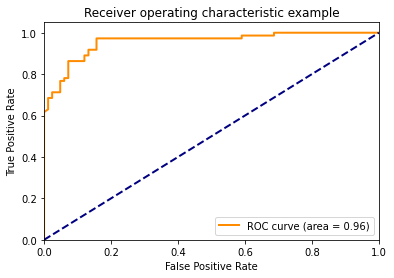

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0
 1 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0
 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0
 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1
 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 

Epoch 1/80
39/39 [==============================] - 18s 453ms/step - loss: 4.0424 - AUC: 0.7633 - Precision: 0.7010 - TP: 279.0000 - FP: 119.0000 - TN: 273.0000 - FN: 108.0000 - acc: 0.6645
Epoch 2/80
39/39 [==============================] - 18s 451ms/step - loss: 0.7623 - AUC: 0.8756 - Precision: 0.8226 - TP: 255.0000 - FP: 55.0000 - TN: 254.0000 - FN: 59.0000 - acc: 0.8170
Epoch 3/80
39/39 [==============================] - 18s 453ms/step - loss: 0.7155 - AUC: 0.9028 - Precision: 0.8381 - TP: 264.0000 - FP: 51.0000 - TN: 258.0000 - FN: 50.0000 - acc: 0.8379
Epoch 4/80
39/39 [==============================] - 18s 452ms/step - loss: 0.4506 - AUC: 0.9438 - Precision: 0.8825 - TP: 278.0000 - FP: 37.0000 - TN: 272.0000 - FN: 36.0000 - acc: 0.8828
Epoch 5/80
39/39 [==============================] - 18s 455ms/step - loss: 0.2978 - AUC: 0.9639 - Precision: 0.9082 - TP: 287.0000 - FP: 29.0000 - TN: 280.0000 - FN: 27.0000 - acc: 0.9101
Epoch 6/80
39/39 [==============================] - 18s 45

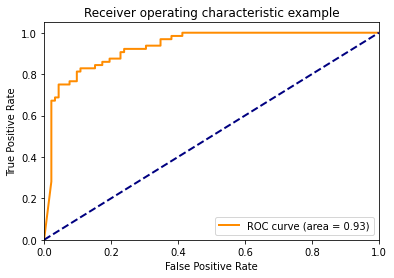

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0
 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0
 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0
 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0
 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0
 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0
 0 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 

Epoch 1/80
39/39 [==============================] - 18s 455ms/step - loss: 4.7225 - AUC: 0.7373 - Precision: 0.6929 - TP: 264.0000 - FP: 117.0000 - TN: 295.0000 - FN: 104.0000 - acc: 0.6827
Epoch 2/80
39/39 [==============================] - 18s 452ms/step - loss: 1.1858 - AUC: 0.8237 - Precision: 0.7557 - TP: 232.0000 - FP: 75.0000 - TN: 245.0000 - FN: 72.0000 - acc: 0.7644
Epoch 3/80
39/39 [==============================] - 18s 458ms/step - loss: 0.8227 - AUC: 0.8859 - Precision: 0.8197 - TP: 250.0000 - FP: 55.0000 - TN: 265.0000 - FN: 54.0000 - acc: 0.8253
Epoch 4/80
39/39 [==============================] - 18s 453ms/step - loss: 0.4110 - AUC: 0.9418 - Precision: 0.8754 - TP: 260.0000 - FP: 37.0000 - TN: 283.0000 - FN: 44.0000 - acc: 0.8702
Epoch 5/80
39/39 [==============================] - 18s 456ms/step - loss: 0.3477 - AUC: 0.9550 - Precision: 0.8914 - TP: 271.0000 - FP: 33.0000 - TN: 287.0000 - FN: 33.0000 - acc: 0.8942
Epoch 6/80
39/39 [==============================] - 18s 45

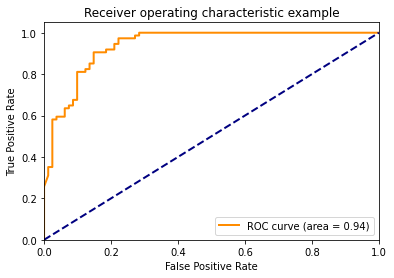

In [21]:
from sklearn.model_selection import KFold
from sklearn.utils import class_weight
from sklearn import metrics
y_trues = []
y_preds = []
AUC = tf.keras.metrics.AUC(name = 'AUC')
Precision = tf.keras.metrics.Precision(name = 'Precision')
TP = tf.keras.metrics.TruePositives(name = 'TP')
FP = tf.keras.metrics.FalsePositives(name = 'FP')
TN = tf.keras.metrics.TrueNegatives(name = 'TN')
FN = tf.keras.metrics.FalseNegatives(name = 'FN')
tps = 0
fps = 0
tns = 0
fns = 0
kf = KFold(n_splits=5,random_state=10, shuffle=True)
for train_index, test_index in kf.split(subjects):
    test = [subjects[i] for i in test_index]
    train = [subjects[i] for i in train_index]
    y_train= [i.label for i in train]
    y_train = np.array(y_train)
    weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)
    weights = {0:weights[0],1:weights[1]}
    train_gen = SubjectGenerator(train,batch_size = 16,shuffle = True)
    test_gen = SubjectGenerator(test,batch_size=16)
    efficient2 = Leaky_EfficientNet()
    efficient2.compile(optimizer = tf.keras.optimizers.Adadelta(lr = 0.1,rho = 0.9),loss = 'binary_crossentropy',metrics = [AUC,Precision,TP,FP,TN,FN,'acc'])
    efficient2.fit_generator(train_gen,epochs = 40 , verbose=1,class_weight=weights)
    y_true = test_gen.get_labels()
    y_pred = efficient2.predict_generator(test_gen)
    y_trues.append(y_true)
    y_preds.append(y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    eva = efficient2.evaluate_generator(test_gen)
    tp,fp,tn,fn = eva[3:7]
    tps += tp
    fps += fp
    tns += tn
    fns += fn
    
    

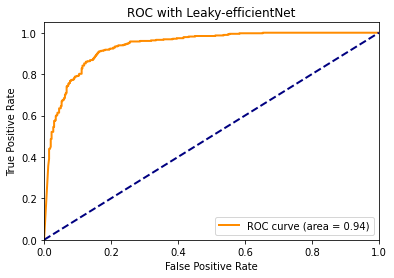

In [22]:
y_true = np.concatenate([y_trues[0],y_trues[1],y_trues[2],y_trues[3],y_trues[4]])
y_pred = np.concatenate([y_preds[0],y_preds[1],y_preds[2],y_preds[3],y_preds[4]])
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with Leaky-efficientNet')
plt.legend(loc="lower right")
plt.show()

In [23]:
print('TPR :: {}'.format(tps/(tps+fns)))
print('TNR :: {}'.format(tns/(tns+fps)))
print('PPV :: {}'.format(tps/(tps+fps)))
print('ACC :: {}'.format((tps+tns)/(fps+fns+tps+tns)))

TPR :: 0.8624338624338624
TNR :: 0.8628428927680798
PPV :: 0.8556430446194225
ACC :: 0.8626444159178434


In [67]:
#efficient2.save_weights('efficient_Leaky.h5')

In [21]:
efficient2 = Leaky_EfficientNet()
efficient2.load_weights('efficient_Leaky.h5')

In [18]:
def multi_conv_model():
  Alpha = 0.4
  input1 = Input(shape = (100,100,10,1))
  #p1 = MaxPool3D(pool_size=(2,2,2))(input1)
  conv1= Conv3D(39,(3,3,3),padding='same')(input1)
    
  conv2= Conv3D(39,(5,5,5),padding='same')(input1)
  
  conv3= Conv3D(39,(7,7,7),padding='same')(input1)
  
  conv4= Conv3D(39,(9,9,9),padding='same')(input1)

  features = concatenate([conv1,conv2,conv3,conv4])
  lk = LeakyReLU(alpha=Alpha)(features)


  bn1_1_1 = BatchNormalization()(lk)

  conv1_1_2= Conv3D(39,(3,3,3),padding='same')(bn1_1_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_1_2)
  bn1_1_2 = BatchNormalization()(lk)

  conv1_1_3= Conv3D(39,(3,3,3),padding='same')(bn1_1_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_1_3)
  bn1_1_3 = BatchNormalization()(lk)
  # ------------------------------------------
  p1_1 = MaxPool3D(pool_size=(2,2,1))(bn1_1_3)

  conv1_2_1= Conv3D(77,(3,3,3),padding='same')(p1_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_2_1)
  bn1_2_1 = BatchNormalization()(lk)

  conv1_2_2= Conv3D(77,(3,3,3),padding='same')(bn1_2_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_2_2)
  bn1_2_2 = BatchNormalization()(lk)

  conv1_2_3= Conv3D(77,(3,3,3),padding='same')(bn1_2_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_2_3)
  bn1_2_3 = BatchNormalization()(lk)

  # ------------------------------------------

  p1_2 = MaxPool3D(pool_size=(2,2,1))(bn1_2_3)


  conv1_3_1= Conv3D(154,(3,3,3),padding='same')(p1_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_3_1)
  bn1_3_1 = BatchNormalization()(lk)

  conv1_3_2= Conv3D(154,(3,3,3),padding='same')(bn1_3_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_3_2)
  bn1_3_2 = BatchNormalization()(lk)

  conv1_3_3= Conv3D(154,(3,3,3),padding='same')(bn1_3_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_3_3)
  bn1_3_3 = BatchNormalization()(lk)


  # ------------------------------------------
  p1_3 = MaxPool3D(pool_size=(2,2,1))(bn1_3_3)


  conv1_4_1= Conv3D(309,(3,3,3),padding='same')(p1_3)
  lk = LeakyReLU(alpha=Alpha)(conv1_4_1)
  bn1_4_1 = BatchNormalization()(lk)

  conv1_4_2= Conv3D(309,(3,3,3),padding='same')(bn1_4_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_4_2)
  bn1_4_2 = BatchNormalization()(lk)


  conv1_4_3= Conv3D(309,(3,3,3),padding='same')(bn1_4_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_4_3)
  bn1_4_3 = BatchNormalization()(lk)


  # ------------------------------------------

  p1_4 = MaxPool3D(pool_size=(2,2,1))(bn1_4_3)


  conv1_5_1= Conv3D(620,(3,3,3),padding='same')(p1_4)
  lk = LeakyReLU(alpha=Alpha)(conv1_5_1)
  bn1_5_1 = BatchNormalization()(lk)

  conv1_5_2= Conv3D(620,(3,3,3),padding='same')(bn1_5_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_5_2)
  bn1_5_2 = BatchNormalization()(lk)

  conv1_5_3= Conv3D(620,(3,3,3),padding='same')(bn1_5_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_5_3)
  bn1_5_3 = BatchNormalization()(lk)
  features =  Flatten()(bn1_5_3)
  main_out = Dense(1,activation=tf.nn.sigmoid)(features)
  model = tf.keras.models.Model([input1],[main_out])
  return model
    

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
39/39 [==============================] - 70s 2s/step - loss: 3.7869 - AUC: 0.6059 - Precision: 0.5686 - TP: 170.0000 - FP: 129.0000 - TN: 200.0000 - FN: 124.0000 - acc: 0.5939
Epoch 2/20
39/39 [==============================] - 68s 2s/step - loss: 1.3417 - AUC: 0.7899 - Precision: 0.7216 - TP: 210.0000 - FP: 81.0000 - TN: 248.0000 - FN: 84.0000 - acc: 0.7352
Epoch 3/20
39/39 [==============================] - 68s 2s/step - loss: 1.8158 - AUC: 0.7334 - Precision: 0.6748 - TP: 193.0000 - FP: 93.0000 - TN: 236.0000 - FN: 101.0000 - acc: 0.6886
Epoch 4/20
39/39 [==============================] - 67s 2s/step - loss: 1.6392 - AUC: 0.7693 - Precision: 0.6852 - TP: 209.0000 - FP: 96.0000 - TN: 233.0000 - FN: 85.0000 - acc: 0.7095
Epoch 5/20
39/39 [==============================] - 68s 2s/step - loss: 1.2850 - AUC: 0.8152 - Precision: 0.7251 - TP: 211.0000 - FP: 80.0000 - TN: 249.0000 - FN: 83.0000 - acc: 0.7

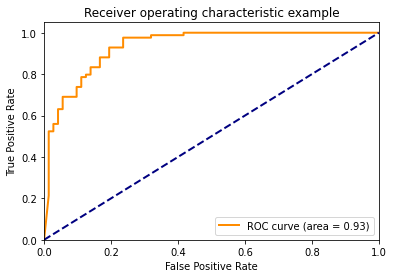

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [19]:
from sklearn.model_selection import KFold
from sklearn import metrics
y_trues = []
y_preds = []
AUC = tf.keras.metrics.AUC(name = 'AUC')
Precision = tf.keras.metrics.Precision(name = 'Precision')
TP = tf.keras.metrics.TruePositives(name = 'TP')
FP = tf.keras.metrics.FalsePositives(name = 'FP')
TN = tf.keras.metrics.TrueNegatives(name = 'TN')
FN = tf.keras.metrics.FalseNegatives(name = 'FN')
tps = 0
fps = 0
tns = 0
fns = 0
kf = KFold(n_splits=5,random_state=10, shuffle=True)
for train_index, test_index in kf.split(subjects):
    test = [subjects[i] for i in test_index]
    train = [subjects[i] for i in train_index]
    
    train_gen = SubjectGenerator2(train,batch_size = 16,shuffle = True)
    test_gen = SubjectGenerator2(test,batch_size=16)
    efficient1 = multi_conv_model()
    efficient1.compile(optimizer = tf.keras.optimizers.Adadelta(lr = 0.1,rho = 0.9),loss = 'binary_crossentropy',metrics = [AUC,Precision,TP,FP,TN,FN,'acc'])
    efficient1.fit_generator(train_gen,epochs = 20 , verbose=1)
    y_true = test_gen.get_labels()
    y_pred = efficient1.predict_generator(test_gen)
    y_trues.append(y_true)
    y_preds.append(y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    eva = efficient1.evaluate_generator(test_gen)
    tp,fp,tn,fn = eva[3:7]
    tps += tp
    fps += fp
    tns += tn
    fns += fn
    break
    

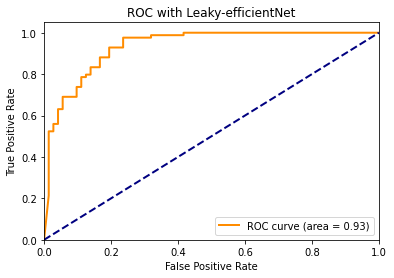

In [20]:
y_true = y_trues[0]
y_pred = y_preds[0]
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with Leaky-efficientNet')
plt.legend(loc="lower right")
plt.show()

In [29]:
test = type3.evaluate_generator(test_gen)
tp,fp,tn,fn = test[3:7]
print('TPR :: {}'.format(tp/(tp+fn)))
print('TNR :: {}'.format(tn/(tn+fp)))
print('PPV :: {}'.format(test[2]))
print('ACC :: {}'.format(test[7]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
TPR :: 0.8615384615384616
TNR :: 0.8444444444444444
PPV :: 0.800000011920929
ACC :: 0.85161292552948


In [17]:
from tensorflow.keras.layers import *

def Shared_Leaky_EfficientNet():
  #baseline1 architecture
  input1 = Input(shape=(100,100,10,1))
  input2 = Input(shape=(50,50,5,1))
  Alpha = 0.1
  #####
  ##shared network
  #####
  
  inp = Input(shape=(50,50,5,1))
  conv2_1_1= Conv3D(39,(3,3,3),padding='same')(inp)
  lk = LeakyReLU(alpha=Alpha)(conv2_1_1)
  bn2_1_1 = BatchNormalization()(lk)

  conv2_1_2= Conv3D(39,(3,3,3),padding='same')(bn2_1_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_1_2)
  bn2_1_2 = BatchNormalization()(lk)

  conv2_1_3= Conv3D(39,(3,3,3),padding='same')(bn2_1_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_1_3)
  bn2_1_3 = BatchNormalization()(lk)

  # ------------------------------------------

  p2_1 = MaxPool3D(pool_size=(2,2,1))(bn2_1_3)

  conv2_2_1= Conv3D(77,(3,3,3),padding='same')(p2_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_2_1)
  bn2_2_1 = BatchNormalization()(lk)

  conv2_2_2= Conv3D(77,(3,3,3),padding='same')(bn2_2_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_2_2)
  bn2_2_2 = BatchNormalization()(lk)

  conv2_2_3= Conv3D(77,(3,3,3),padding='same')(bn2_2_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_2_3)
  bn2_2_3 = BatchNormalization()(lk)

  # ------------------------------------------
  p2_2 = MaxPool3D(pool_size=(2,2,1))(bn2_2_3)


  conv2_3_1= Conv3D(154,(3,3,3),padding='same')(p2_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_3_1)
  bn2_3_1 = BatchNormalization()(lk)

  conv2_3_2= Conv3D(154,(3,3,3),padding='same')(bn2_3_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_3_2)
  bn2_3_2 = BatchNormalization()(lk)

  conv2_3_3= Conv3D(154,(3,3,3),padding='same')(bn2_3_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_3_3)
  bn2_3_3 = BatchNormalization()(lk)

  # ------------------------------------------
  p2_3 = MaxPool3D(pool_size=(2,2,1))(bn2_3_3)


  conv2_4_1= Conv3D(309,(3,3,3),padding='same')(p2_3)
  lk = LeakyReLU(alpha=Alpha)(conv2_4_1)
  bn2_4_1 = BatchNormalization()(lk)

  conv2_4_2= Conv3D(309,(3,3,3),padding='same')(bn2_4_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_4_2)
  bn2_4_2 = BatchNormalization()(lk)

  conv2_4_3= Conv3D(309,(3,3,3),padding='same')(bn2_4_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_4_3)
  bn2_4_3 = BatchNormalization()(lk)
  # ------------------------------------------
  p2_4 = MaxPool3D(pool_size=(2,2,1))(bn2_4_3)


  conv2_5_1= Conv3D(620,(3,3,3),padding='same')(p2_4)
  lk = LeakyReLU(alpha=Alpha)(conv2_5_1)
  bn2_5_1 = BatchNormalization()(lk)

  conv2_5_2= Conv3D(620,(3,3,3),padding='same')(bn2_5_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_5_2)
  bn2_5_2 = BatchNormalization()(lk)

  conv2_5_3= Conv3D(620,(3,3,3),padding='same')(bn2_5_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_5_3)
  bn2_5_3 = BatchNormalization()(lk)

  base_model = tf.keras.models.Model(inputs=[inp],outputs=[bn2_5_3])
  # ------------------------------------------
  mid1 = MaxPool3D(pool_size=(2,2,2))(input1)
  out1 = base_model(mid1)
  out2 = base_model(input2)

  ####
  ##concat
  ####

  concat = concatenate([out1,out2])
  features =  Flatten()(concat)
  main_out = Dense(1,activation=tf.nn.sigmoid)(features)
  model = tf.keras.models.Model([input1,input2],[main_out])
  return model

Epoch 1/20
39/39 [==============================] - 18s 460ms/step - loss: 2.9157 - AUC: 0.6634 - Precision: 0.6250 - TP: 180.0000 - FP: 108.0000 - TN: 221.0000 - FN: 114.0000 - acc: 0.6437
Epoch 2/20
39/39 [==============================] - 18s 455ms/step - loss: 0.8686 - AUC: 0.8611 - Precision: 0.7767 - TP: 233.0000 - FP: 67.0000 - TN: 262.0000 - FN: 61.0000 - acc: 0.7945
Epoch 3/20
39/39 [==============================] - 18s 455ms/step - loss: 0.5720 - AUC: 0.8906 - Precision: 0.8136 - TP: 240.0000 - FP: 55.0000 - TN: 274.0000 - FN: 54.0000 - acc: 0.8250
Epoch 4/20
39/39 [==============================] - 18s 455ms/step - loss: 0.5047 - AUC: 0.9128 - Precision: 0.8414 - TP: 244.0000 - FP: 46.0000 - TN: 283.0000 - FN: 50.0000 - acc: 0.8459
Epoch 5/20
39/39 [==============================] - 18s 454ms/step - loss: 0.3293 - AUC: 0.9592 - Precision: 0.9014 - TP: 265.0000 - FP: 29.0000 - TN: 300.0000 - FN: 29.0000 - acc: 0.9069
Epoch 6/20
39/39 [==============================] - 18s 45

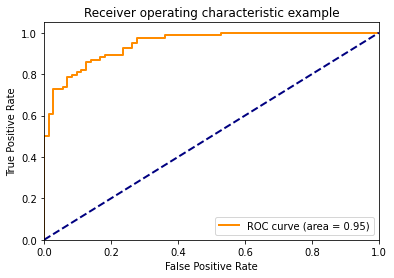

Instructions for updating:
Please use Model.evaluate, which supports generators.
Epoch 1/20
39/39 [==============================] - 18s 454ms/step - loss: 2.7275 - AUC: 0.7812 - Precision: 0.7239 - TP: 270.0000 - FP: 103.0000 - TN: 297.0000 - FN: 109.0000 - acc: 0.6982
Epoch 2/20
39/39 [==============================] - 18s 457ms/step - loss: 1.1805 - AUC: 0.8590 - Precision: 0.7952 - TP: 233.0000 - FP: 60.0000 - TN: 268.0000 - FN: 62.0000 - acc: 0.8042
Epoch 3/20
39/39 [==============================] - 18s 451ms/step - loss: 0.8072 - AUC: 0.9078 - Precision: 0.8378 - TP: 248.0000 - FP: 48.0000 - TN: 280.0000 - FN: 47.0000 - acc: 0.8475
Epoch 4/20
39/39 [==============================] - 18s 455ms/step - loss: 0.3733 - AUC: 0.9535 - Precision: 0.8889 - TP: 264.0000 - FP: 33.0000 - TN: 295.0000 - FN: 31.0000 - acc: 0.8973
Epoch 5/20
39/39 [==============================] - 18s 453ms/step - loss: 0.3393 - AUC: 0.9635 - Precision: 0.9038 - TP: 263.0000 - FP: 28.0000 - TN: 300.0000 - FN:

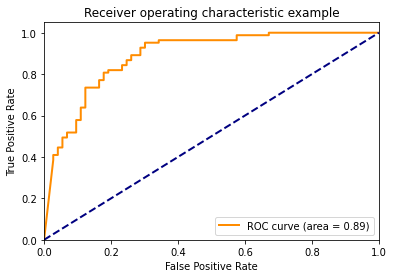

Epoch 1/20
39/39 [==============================] - 18s 456ms/step - loss: 2.9718 - AUC: 0.7324 - Precision: 0.6827 - TP: 256.0000 - FP: 119.0000 - TN: 272.0000 - FN: 132.0000 - acc: 0.6501
Epoch 2/20
39/39 [==============================] - 18s 452ms/step - loss: 0.8350 - AUC: 0.8844 - Precision: 0.8208 - TP: 252.0000 - FP: 55.0000 - TN: 263.0000 - FN: 53.0000 - acc: 0.8266
Epoch 3/20
39/39 [==============================] - 18s 450ms/step - loss: 0.5149 - AUC: 0.9179 - Precision: 0.8469 - TP: 260.0000 - FP: 47.0000 - TN: 271.0000 - FN: 45.0000 - acc: 0.8523
Epoch 4/20
39/39 [==============================] - 18s 453ms/step - loss: 0.3782 - AUC: 0.9402 - Precision: 0.8614 - TP: 261.0000 - FP: 42.0000 - TN: 276.0000 - FN: 44.0000 - acc: 0.8620
Epoch 5/20
39/39 [==============================] - 18s 457ms/step - loss: 0.3941 - AUC: 0.9472 - Precision: 0.8770 - TP: 271.0000 - FP: 38.0000 - TN: 280.0000 - FN: 34.0000 - acc: 0.8844
Epoch 6/20
39/39 [==============================] - 18s 45

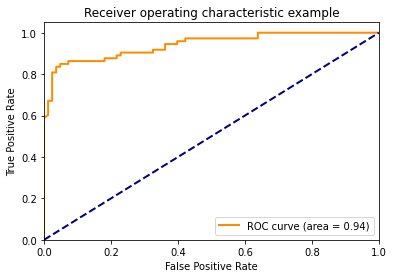

Epoch 1/20
39/39 [==============================] - 18s 452ms/step - loss: 2.9889 - AUC: 0.7482 - Precision: 0.7121 - TP: 277.0000 - FP: 112.0000 - TN: 280.0000 - FN: 110.0000 - acc: 0.6854
Epoch 2/20
39/39 [==============================] - 18s 454ms/step - loss: 0.8819 - AUC: 0.8760 - Precision: 0.8089 - TP: 254.0000 - FP: 60.0000 - TN: 249.0000 - FN: 60.0000 - acc: 0.8074
Epoch 3/20
39/39 [==============================] - 18s 455ms/step - loss: 0.6793 - AUC: 0.9347 - Precision: 0.8917 - TP: 280.0000 - FP: 34.0000 - TN: 275.0000 - FN: 34.0000 - acc: 0.8909
Epoch 4/20
39/39 [==============================] - 18s 454ms/step - loss: 0.5808 - AUC: 0.9374 - Precision: 0.8867 - TP: 274.0000 - FP: 35.0000 - TN: 274.0000 - FN: 40.0000 - acc: 0.8796
Epoch 5/20
39/39 [==============================] - 18s 452ms/step - loss: 0.5273 - AUC: 0.9460 - Precision: 0.8972 - TP: 288.0000 - FP: 33.0000 - TN: 276.0000 - FN: 26.0000 - acc: 0.9053
Epoch 6/20
39/39 [==============================] - 18s 45

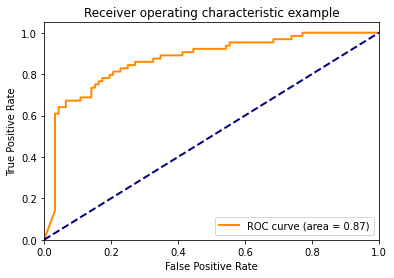

Epoch 1/20
39/39 [==============================] - 18s 456ms/step - loss: 2.8683 - AUC: 0.7431 - Precision: 0.6811 - TP: 252.0000 - FP: 118.0000 - TN: 294.0000 - FN: 116.0000 - acc: 0.6731
Epoch 2/20
39/39 [==============================] - 18s 454ms/step - loss: 0.9026 - AUC: 0.8624 - Precision: 0.7987 - TP: 238.0000 - FP: 60.0000 - TN: 260.0000 - FN: 66.0000 - acc: 0.7981
Epoch 3/20
39/39 [==============================] - 18s 459ms/step - loss: 0.8062 - AUC: 0.8787 - Precision: 0.8033 - TP: 245.0000 - FP: 60.0000 - TN: 260.0000 - FN: 59.0000 - acc: 0.8093
Epoch 4/20
39/39 [==============================] - 18s 455ms/step - loss: 0.2874 - AUC: 0.9591 - Precision: 0.9107 - TP: 265.0000 - FP: 26.0000 - TN: 294.0000 - FN: 39.0000 - acc: 0.8958
Epoch 5/20
39/39 [==============================] - 18s 452ms/step - loss: 0.2184 - AUC: 0.9728 - Precision: 0.9129 - TP: 283.0000 - FP: 27.0000 - TN: 293.0000 - FN: 21.0000 - acc: 0.9231
Epoch 6/20
39/39 [==============================] - 18s 45

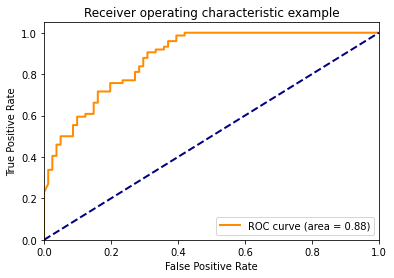

In [19]:
from sklearn.model_selection import KFold
from sklearn import metrics
y_trues = []
y_preds = []
AUC = tf.keras.metrics.AUC(name = 'AUC')
Precision = tf.keras.metrics.Precision(name = 'Precision')
TP = tf.keras.metrics.TruePositives(name = 'TP')
FP = tf.keras.metrics.FalsePositives(name = 'FP')
TN = tf.keras.metrics.TrueNegatives(name = 'TN')
FN = tf.keras.metrics.FalseNegatives(name = 'FN')
tps = 0
fps = 0
tns = 0
fns = 0
kf = KFold(n_splits=5,random_state=10, shuffle=True)
for train_index, test_index in kf.split(subjects):
    test = [subjects[i] for i in test_index]
    train = [subjects[i] for i in train_index]
    
    train_gen = SubjectGenerator(train,batch_size = 16,shuffle = True)
    test_gen = SubjectGenerator(test,batch_size=16)
    efficient2 = Shared_Leaky_EfficientNet()
    efficient2.compile(optimizer = tf.keras.optimizers.Adadelta(lr = 0.1,rho = 0.9),loss = 'binary_crossentropy',metrics = [AUC,Precision,TP,FP,TN,FN,'acc'])
    efficient2.fit_generator(train_gen,epochs = 20 , verbose=1)
    y_true = test_gen.get_labels()
    y_pred = efficient2.predict_generator(test_gen)
    y_trues.append(y_true)
    y_preds.append(y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    eva = efficient2.evaluate_generator(test_gen)
    tp,fp,tn,fn = eva[3:7]
    tps += tp
    fps += fp
    tns += tn
    fns += fn
    
    

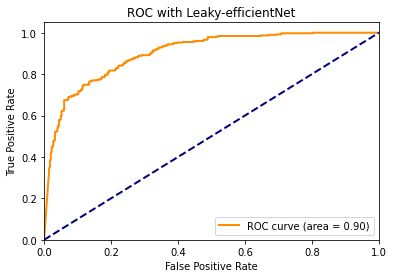

In [20]:
y_true = np.concatenate([y_trues[0],y_trues[1],y_trues[2],y_trues[3],y_trues[4]])
y_pred = np.concatenate([y_preds[0],y_preds[1],y_preds[2],y_preds[3],y_preds[4]])
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with Leaky-efficientNet')
plt.legend(loc="lower right")
plt.show()

In [21]:
print('TPR :: {}'.format(tps/(tps+fns)))
print('TNR :: {}'.format(tns/(tns+fps)))
print('PPV :: {}'.format(tps/(tps+fps)))
print('ACC :: {}'.format((tps+tns)/(fps+fns+tps+tns)))

TPR :: 0.7857142857142857
TNR :: 0.827930174563591
PPV :: 0.8114754098360656
ACC :: 0.8074454428754814


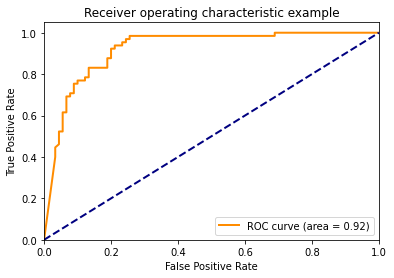

In [24]:
from sklearn import metrics
y_true = []
for i,d in enumerate(test_data):
    y_true.append(test_data[d])
y_true = np.array(y_true,np.int)

fpr, tpr, _ = metrics.roc_curve(y_true, outp)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [25]:
test = incep_eff.evaluate_generator(test_gen)
tp,fp,tn,fn = test[3:7]
print('TPR :: {}'.format(tp/(tp+fn)))
print('TNR :: {}'.format(tn/(tn+fp)))
print('PPV :: {}'.format(test[2]))
print('ACC :: {}'.format(test[7]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
TPR :: 0.8307692307692308
TNR :: 0.8222222222222222
PPV :: 0.7714285850524902
ACC :: 0.8258064389228821


In [19]:
def ResBlock(layer_in,size):
  Alpha = 0.3
  conv1_3_1= Conv3D(size,(3,3,3),padding='same')(layer_in)
  lk = LeakyReLU(alpha=Alpha)(conv1_3_1)
  bn1_3_1 = BatchNormalization()(lk)

  conv1_3_2= Conv3D(size,(3,3,3),padding='same')(bn1_3_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_3_2)
  bn1_3_2 = BatchNormalization()(lk)

  conv1_3_3= Conv3D(size,(3,3,3),padding='same')(bn1_3_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_3_3)
    
  concat = concatenate([conv1_3_1,conv1_3_3])
  bn1_3_3 = BatchNormalization()(concat)
    
  return bn1_3_3
    

In [20]:
from tensorflow.keras.layers import *

def Residual_EfficientNet():
  #baseline1 architecture
  input1 = Input(shape=(100,100,10,1))
  input2 = Input(shape=(50,50,5,1))
  Alpha = 0.2
  #####
  ##first path
  #####

  p1 = MaxPool3D(pool_size=(2,2,2))(input1)

  Res1_1 = ResBlock(p1,39)
  # ------------------------------------------
  p1_1 = MaxPool3D(pool_size=(2,2,1))(Res1_1)

  Res1_2 = ResBlock(p1_1,77)

  # ------------------------------------------

  p1_2 = MaxPool3D(pool_size=(2,2,1))(Res1_2)


  Res1_3 = ResBlock(p1_2,154)


  # ------------------------------------------
  p1_3 = MaxPool3D(pool_size=(2,2,1))(Res1_3)


  Res1_4 = ResBlock(p1_3,309)


  # ------------------------------------------

  p1_4 = MaxPool3D(pool_size=(2,2,1))(Res1_4)


  Res1_5 = ResBlock(p1_4,620)

  # ------------------------------------------

  #####
  ##second path
  #####


  Res2_1 = ResBlock(input2,39)

  # ------------------------------------------

  p2_1 = MaxPool3D(pool_size=(2,2,1))(Res2_1)

  Res2_2 = ResBlock(p2_1,77)

  # ------------------------------------------
  p2_2 = MaxPool3D(pool_size=(2,2,1))(Res2_2)


  Res2_3 = ResBlock(p2_2,154)

  # ------------------------------------------
  p2_3 = MaxPool3D(pool_size=(2,2,1))(Res2_3)


  Res2_4 = ResBlock(p2_3,309)
  # ------------------------------------------
  p2_4 = MaxPool3D(pool_size=(2,2,1))(Res2_4)


  Res2_5 = ResBlock(p2_4,620)
  # ------------------------------------------


  ####
  ##concat
  ####

  concat = concatenate([Res2_5,Res1_5])
  features =  Flatten()(concat)
  main_out = Dense(1,activation=tf.nn.sigmoid)(features)
  model = tf.keras.models.Model([input1,input2],[main_out])
  return model

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0
 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0
 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1
 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0
 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1
 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0
 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
39/39 [==============================] - 18s 469ms/step - loss: 5.4592 - AUC: 0.6731 - Precision: 0.6151 - TP: 187.0000 - FP: 117.0000 - TN: 212.0000 - FN: 107.0000 - acc: 0.6404
Epoch 2/80
39/39 [==============================] - 18s 462ms/step - loss: 1.7006 - AUC: 0.8215 - Precision: 0.7401 - TP: 225.0000 - FP: 79.0000 - TN: 250.0000 - FN: 69.0000 - acc: 0.7624
Epoch 3/80
39/39 [==============================] - 18s 463ms/step - loss: 1.2910 - AUC: 0.8389 - Precision: 0.7451 - TP: 228.0000 - FP: 78.0000 - TN: 251.0000 - FN: 66.0000 - acc: 0.7689
Epoch 4/80
39/39 [==============================] - 18s 460ms/step - loss: 0.6679 - AUC: 0.9189 - Precision: 0.8396 - TP: 246.0000 - FP: 47.0000 - TN: 282.0000 - FN: 48.0000 - acc: 0.8475
Epoch 5/80
39/39 [==============================] - 18s 464ms/step - loss: 0.7348 - AUC: 0.9100 - Precision: 0.8295 - TP: 253.0000 - FP: 52.0000 - TN: 277.0000 - FN: 41.0

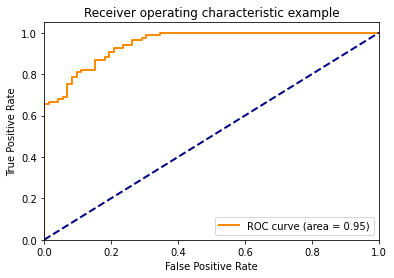

Instructions for updating:
Please use Model.evaluate, which supports generators.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1
 1 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0
 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0
 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1
 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0
 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0
 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 

Epoch 1/80
39/39 [==============================] - 18s 464ms/step - loss: 5.7596 - AUC: 0.7148 - Precision: 0.6658 - TP: 261.0000 - FP: 131.0000 - TN: 269.0000 - FN: 118.0000 - acc: 0.6388
Epoch 2/80
39/39 [==============================] - 18s 464ms/step - loss: 1.5922 - AUC: 0.8402 - Precision: 0.7566 - TP: 230.0000 - FP: 74.0000 - TN: 254.0000 - FN: 65.0000 - acc: 0.7769
Epoch 3/80
39/39 [==============================] - 18s 466ms/step - loss: 1.2234 - AUC: 0.8819 - Precision: 0.8087 - TP: 241.0000 - FP: 57.0000 - TN: 271.0000 - FN: 54.0000 - acc: 0.8218
Epoch 4/80
39/39 [==============================] - 18s 465ms/step - loss: 0.9265 - AUC: 0.8860 - Precision: 0.8060 - TP: 241.0000 - FP: 58.0000 - TN: 270.0000 - FN: 54.0000 - acc: 0.8202
Epoch 5/80
39/39 [==============================] - 18s 465ms/step - loss: 0.5581 - AUC: 0.9418 - Precision: 0.8931 - TP: 259.0000 - FP: 31.0000 - TN: 297.0000 - FN: 36.0000 - acc: 0.8925
Epoch 6/80
39/39 [==============================] - 18s 46

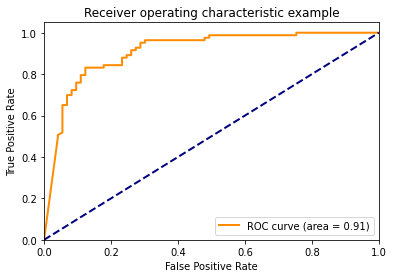

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1
 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1
 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1
 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1
 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0
 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 

Epoch 1/80
39/39 [==============================] - 18s 464ms/step - loss: 5.0942 - AUC: 0.7292 - Precision: 0.6899 - TP: 267.0000 - FP: 120.0000 - TN: 271.0000 - FN: 121.0000 - acc: 0.6549
Epoch 2/80
39/39 [==============================] - 18s 464ms/step - loss: 1.6188 - AUC: 0.8169 - Precision: 0.7363 - TP: 229.0000 - FP: 82.0000 - TN: 236.0000 - FN: 76.0000 - acc: 0.7464
Epoch 3/80
39/39 [==============================] - 18s 466ms/step - loss: 1.3226 - AUC: 0.8392 - Precision: 0.7848 - TP: 237.0000 - FP: 65.0000 - TN: 253.0000 - FN: 68.0000 - acc: 0.7865
Epoch 4/80
39/39 [==============================] - 18s 467ms/step - loss: 1.1459 - AUC: 0.8529 - Precision: 0.7700 - TP: 241.0000 - FP: 72.0000 - TN: 246.0000 - FN: 64.0000 - acc: 0.7817
Epoch 5/80
39/39 [==============================] - 18s 466ms/step - loss: 0.7602 - AUC: 0.9108 - Precision: 0.8426 - TP: 257.0000 - FP: 48.0000 - TN: 270.0000 - FN: 48.0000 - acc: 0.8459
Epoch 6/80
39/39 [==============================] - 18s 46

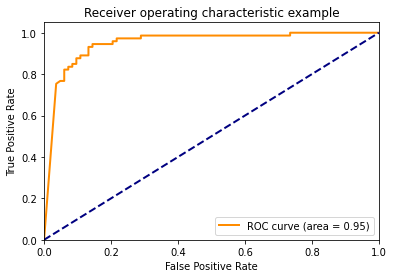

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0
 1 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0
 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0
 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1
 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 

Epoch 1/80
39/39 [==============================] - 18s 464ms/step - loss: 5.1985 - AUC: 0.7499 - Precision: 0.7109 - TP: 273.0000 - FP: 111.0000 - TN: 281.0000 - FN: 114.0000 - acc: 0.6661
Epoch 2/80
39/39 [==============================] - 18s 463ms/step - loss: 1.6232 - AUC: 0.8192 - Precision: 0.7697 - TP: 244.0000 - FP: 73.0000 - TN: 236.0000 - FN: 70.0000 - acc: 0.7705
Epoch 3/80
39/39 [==============================] - 18s 464ms/step - loss: 1.1594 - AUC: 0.8778 - Precision: 0.8252 - TP: 255.0000 - FP: 54.0000 - TN: 255.0000 - FN: 59.0000 - acc: 0.8186
Epoch 4/80
39/39 [==============================] - 18s 466ms/step - loss: 0.9501 - AUC: 0.8904 - Precision: 0.8328 - TP: 259.0000 - FP: 52.0000 - TN: 257.0000 - FN: 55.0000 - acc: 0.8283
Epoch 5/80
39/39 [==============================] - 18s 466ms/step - loss: 0.6131 - AUC: 0.9220 - Precision: 0.8694 - TP: 273.0000 - FP: 41.0000 - TN: 268.0000 - FN: 41.0000 - acc: 0.8684
Epoch 6/80
39/39 [==============================] - 18s 46

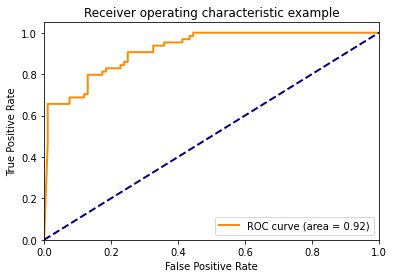

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0
 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0
 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0
 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0
 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0
 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0
 0 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 

Epoch 1/80
39/39 [==============================] - 18s 465ms/step - loss: 4.6552 - AUC: 0.7341 - Precision: 0.6649 - TP: 252.0000 - FP: 127.0000 - TN: 285.0000 - FN: 116.0000 - acc: 0.6571
Epoch 2/80
39/39 [==============================] - 18s 464ms/step - loss: 1.3957 - AUC: 0.8418 - Precision: 0.7745 - TP: 237.0000 - FP: 69.0000 - TN: 251.0000 - FN: 67.0000 - acc: 0.7821
Epoch 3/80
39/39 [==============================] - 18s 467ms/step - loss: 1.2979 - AUC: 0.8666 - Precision: 0.7934 - TP: 242.0000 - FP: 63.0000 - TN: 257.0000 - FN: 62.0000 - acc: 0.7997
Epoch 4/80
39/39 [==============================] - 18s 464ms/step - loss: 1.2447 - AUC: 0.8550 - Precision: 0.8033 - TP: 245.0000 - FP: 60.0000 - TN: 260.0000 - FN: 59.0000 - acc: 0.8093
Epoch 5/80
39/39 [==============================] - 18s 468ms/step - loss: 0.5833 - AUC: 0.9269 - Precision: 0.8680 - TP: 263.0000 - FP: 40.0000 - TN: 280.0000 - FN: 41.0000 - acc: 0.8702
Epoch 6/80
39/39 [==============================] - 18s 46

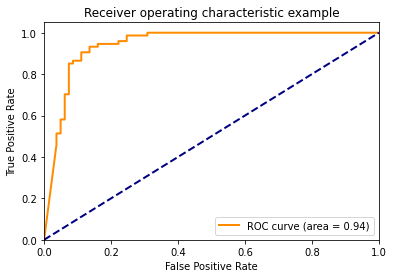

In [21]:
from sklearn.model_selection import KFold
from sklearn.utils import class_weight
from sklearn import metrics
y_trues = []
y_preds = []
AUC = tf.keras.metrics.AUC(name = 'AUC')
Precision = tf.keras.metrics.Precision(name = 'Precision')
TP = tf.keras.metrics.TruePositives(name = 'TP')
FP = tf.keras.metrics.FalsePositives(name = 'FP')
TN = tf.keras.metrics.TrueNegatives(name = 'TN')
FN = tf.keras.metrics.FalseNegatives(name = 'FN')
tps = 0
fps = 0
tns = 0
fns = 0
kf = KFold(n_splits=5,random_state=10, shuffle=True)
for train_index, test_index in kf.split(subjects):
    test = [subjects[i] for i in test_index]
    train = [subjects[i] for i in train_index]
    y_train= [i.label for i in train]
    y_train = np.array(y_train)
    weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)
    weights = {0:weights[0],1:weights[1]}
    train_gen = SubjectGenerator(train,batch_size = 16,shuffle = True)
    test_gen = SubjectGenerator(test,batch_size=16)
    res_eff = Residual_EfficientNet()
    res_eff.compile(optimizer = tf.keras.optimizers.Adadelta(lr = 0.1,rho = 0.9),loss = 'binary_crossentropy',metrics = [AUC,Precision,TP,FP,TN,FN,'acc'])
    res_eff.fit_generator(train_gen,epochs = 80 , verbose=1,class_weight=weights)
    y_true = test_gen.get_labels()
    y_pred = res_eff.predict_generator(test_gen)
    y_trues.append(y_true)
    y_preds.append(y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    eva = res_eff.evaluate_generator(test_gen)
    tp,fp,tn,fn = eva[3:7]
    tps += tp
    fps += fp
    tns += tn
    fns += fn
    
    

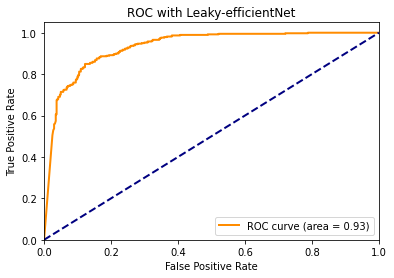

In [22]:
y_true = np.concatenate([y_trues[0],y_trues[1],y_trues[2],y_trues[3],y_trues[4]])
y_pred = np.concatenate([y_preds[0],y_preds[1],y_preds[2],y_preds[3],y_preds[4]])
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with Leaky-efficientNet')
plt.legend(loc="lower right")
plt.show()

In [23]:
print('TPR :: {}'.format(tps/(tps+fns)))
print('TNR :: {}'.format(tns/(tns+fps)))
print('PPV :: {}'.format(tps/(tps+fps)))
print('ACC :: {}'.format((tps+tns)/(fps+fns+tps+tns)))

TPR :: 0.8624338624338624
TNR :: 0.8478802992518704
PPV :: 0.8423772609819121
ACC :: 0.8549422336328626


In [17]:
from tensorflow.keras.layers import *

def Leaky_EfficientNet2():
  #baseline1 architecture
  input1 = Input(shape=(100,100,10,1))
  input2 = Input(shape=(50,50,5,1))
  Alpha = 0.4
  #####
  ##first path
  #####

  p1 = MaxPool3D(pool_size=(2,2,2))(input1)

  conv1_1_1= Conv3D(39,(3,3,3),padding='same')(p1)
  lk = LeakyReLU(alpha=Alpha)(conv1_1_1)
  bn1_1_1 = BatchNormalization()(lk)

  conv1_1_2= Conv3D(39,(3,3,3),padding='same')(bn1_1_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_1_2)
  bn1_1_2 = BatchNormalization()(lk)

  conv1_1_3= Conv3D(39,(3,3,3),padding='same')(bn1_1_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_1_3)
  bn1_1_3 = BatchNormalization()(lk)
  # ------------------------------------------
  p1_1 = MaxPool3D(pool_size=(2,2,1))(bn1_1_3)
  d1_1 = Flatten()(p1_1)
  d1_1 = Dense(1,activation='sigmoid')(d1_1)

  conv1_2_1= Conv3D(77,(3,3,3),padding='same')(p1_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_2_1)
  bn1_2_1 = BatchNormalization()(lk)

  conv1_2_2= Conv3D(77,(3,3,3),padding='same')(bn1_2_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_2_2)
  bn1_2_2 = BatchNormalization()(lk)

  conv1_2_3= Conv3D(77,(3,3,3),padding='same')(bn1_2_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_2_3)
  bn1_2_3 = BatchNormalization()(lk)

  # ------------------------------------------

  p1_2 = MaxPool3D(pool_size=(2,2,1))(bn1_2_3)
  d1_2 = Flatten()(p1_2)
  d1_2 = Dense(1,activation='sigmoid')(d1_2)


  conv1_3_1= Conv3D(154,(3,3,3),padding='same')(p1_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_3_1)
  bn1_3_1 = BatchNormalization()(lk)

  conv1_3_2= Conv3D(154,(3,3,3),padding='same')(bn1_3_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_3_2)
  bn1_3_2 = BatchNormalization()(lk)

  conv1_3_3= Conv3D(154,(3,3,3),padding='same')(bn1_3_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_3_3)
  bn1_3_3 = BatchNormalization()(lk)


  # ------------------------------------------
  p1_3 = MaxPool3D(pool_size=(2,2,1))(bn1_3_3)
  d1_3 = Flatten()(p1_3)
  d1_3 = Dense(1,activation='sigmoid')(d1_3)


  conv1_4_1= Conv3D(309,(3,3,3),padding='same')(p1_3)
  lk = LeakyReLU(alpha=Alpha)(conv1_4_1)
  bn1_4_1 = BatchNormalization()(lk)

  conv1_4_2= Conv3D(309,(3,3,3),padding='same')(bn1_4_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_4_2)
  bn1_4_2 = BatchNormalization()(lk)


  conv1_4_3= Conv3D(309,(3,3,3),padding='same')(bn1_4_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_4_3)
  bn1_4_3 = BatchNormalization()(lk)


  # ------------------------------------------

  p1_4 = MaxPool3D(pool_size=(2,2,1))(bn1_4_3)
  d1_4 = Flatten()(p1_4)
  d1_4 = Dense(1,activation='sigmoid')(d1_4)

  conv1_5_1= Conv3D(620,(3,3,3),padding='same')(p1_4)
  lk = LeakyReLU(alpha=Alpha)(conv1_5_1)
  bn1_5_1 = BatchNormalization()(lk)

  conv1_5_2= Conv3D(620,(3,3,3),padding='same')(bn1_5_1)
  lk = LeakyReLU(alpha=Alpha)(conv1_5_2)
  bn1_5_2 = BatchNormalization()(lk)

  conv1_5_3= Conv3D(620,(3,3,3),padding='same')(bn1_5_2)
  lk = LeakyReLU(alpha=Alpha)(conv1_5_3)
  bn1_5_3 = BatchNormalization()(lk)

  # ------------------------------------------

  #####
  ##second path
  #####


  conv2_1_1= Conv3D(39,(3,3,3),padding='same')(input2)
  lk = LeakyReLU(alpha=Alpha)(conv2_1_1)
  bn2_1_1 = BatchNormalization()(lk)

  conv2_1_2= Conv3D(39,(3,3,3),padding='same')(bn2_1_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_1_2)
  bn2_1_2 = BatchNormalization()(lk)

  conv2_1_3= Conv3D(39,(3,3,3),padding='same')(bn2_1_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_1_3)
  bn2_1_3 = BatchNormalization()(lk)

  # ------------------------------------------

  p2_1 = MaxPool3D(pool_size=(2,2,1))(bn2_1_3)
  d2_1 = Flatten()(p2_1)
  d2_1 = Dense(1,activation='sigmoid')(d2_1)

  conv2_2_1= Conv3D(77,(3,3,3),padding='same')(p2_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_2_1)
  bn2_2_1 = BatchNormalization()(lk)

  conv2_2_2= Conv3D(77,(3,3,3),padding='same')(bn2_2_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_2_2)
  bn2_2_2 = BatchNormalization()(lk)

  conv2_2_3= Conv3D(77,(3,3,3),padding='same')(bn2_2_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_2_3)
  bn2_2_3 = BatchNormalization()(lk)

  # ------------------------------------------
  p2_2 = MaxPool3D(pool_size=(2,2,1))(bn2_2_3)
  d2_2 = Flatten()(p2_2)
  d2_2 = Dense(1,activation='sigmoid')(d2_2)


  conv2_3_1= Conv3D(154,(3,3,3),padding='same')(p2_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_3_1)
  bn2_3_1 = BatchNormalization()(lk)

  conv2_3_2= Conv3D(154,(3,3,3),padding='same')(bn2_3_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_3_2)
  bn2_3_2 = BatchNormalization()(lk)

  conv2_3_3= Conv3D(154,(3,3,3),padding='same')(bn2_3_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_3_3)
  bn2_3_3 = BatchNormalization()(lk)

  # ------------------------------------------
  p2_3 = MaxPool3D(pool_size=(2,2,1))(bn2_3_3)
  d2_3 = Flatten()(p2_3)
  d2_3 = Dense(1,activation='sigmoid')(d2_3)


  conv2_4_1= Conv3D(309,(3,3,3),padding='same')(p2_3)
  lk = LeakyReLU(alpha=Alpha)(conv2_4_1)
  bn2_4_1 = BatchNormalization()(lk)

  conv2_4_2= Conv3D(309,(3,3,3),padding='same')(bn2_4_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_4_2)
  bn2_4_2 = BatchNormalization()(lk)

  conv2_4_3= Conv3D(309,(3,3,3),padding='same')(bn2_4_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_4_3)
  bn2_4_3 = BatchNormalization()(lk)
  # ------------------------------------------
  p2_4 = MaxPool3D(pool_size=(2,2,1))(bn2_4_3)
  d2_4 = Flatten()(p2_4)
  d2_4 = Dense(1,activation='sigmoid')(d2_4)


  conv2_5_1= Conv3D(620,(3,3,3),padding='same')(p2_4)
  lk = LeakyReLU(alpha=Alpha)(conv2_5_1)
  bn2_5_1 = BatchNormalization()(lk)

  conv2_5_2= Conv3D(620,(3,3,3),padding='same')(bn2_5_1)
  lk = LeakyReLU(alpha=Alpha)(conv2_5_2)
  bn2_5_2 = BatchNormalization()(lk)

  conv2_5_3= Conv3D(620,(3,3,3),padding='same')(bn2_5_2)
  lk = LeakyReLU(alpha=Alpha)(conv2_5_3)
  bn2_5_3 = BatchNormalization()(lk)
  # ------------------------------------------


  ####
  ##concat
  ####

  concat = concatenate([bn2_5_3,bn1_5_3])
  features =  Flatten()(concat)
  main_out = Dense(1,activation=tf.nn.sigmoid)(features)
  model = tf.keras.models.Model([input1,input2],[main_out,d1_1,d1_2,d1_3,d1_4,d2_1,d2_2,d2_3,d2_4])
  return model

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
39/39 [==============================] - 19s 477ms/step - loss: 10.7116 - dense_8_loss: 4.2036 - dense_loss: 0.7966 - dense_1_loss: 0.7296 - dense_2_loss: 0.7174 - dense_3_loss: 1.3225 - dense_4_loss: 0.6988 - dense_5_loss: 0.6291 - dense_6_loss: 0.6352 - dense_7_loss: 0.9789 - dense_8_AUC: 0.6919 - dense_8_Precision: 0.6421 - dense_8_TP: 192.0000 - dense_8_FP: 107.0000 - dense_8_TN: 222.0000 - dense_8_FN: 102.0000 - dense_8_acc: 0.6645 - dense_AUC: 0.6867 - dense_Precision: 0.6208 - dense_TP: 185.0000 - dense_FP: 113.0000 - dense_TN: 216.0000 - dense_FN: 109.0000 - dense_acc: 0.6437 - dense_1_AUC: 0.6825 - dense_1_Precision: 0.5822 - dense_1_TP: 170.0000 - dense_1_FP: 122.0000 - dense_1_TN: 207.0000 - dense_1_FN: 124.0000 - dense_1_acc: 0.6051 - dense_2_AUC: 0.7210 - dense_2_Precision: 0.6479 - dense_2_TP: 184.0000 - dense_2_FP: 100.0000 - dense_2_TN: 229.0000 - dense_2_FN: 110.0000 - dense_2_acc: 0

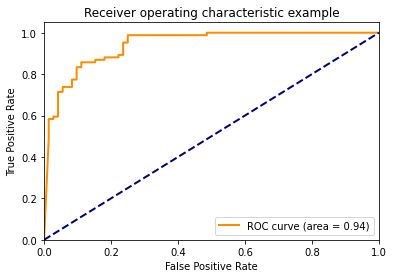

Instructions for updating:
Please use Model.evaluate, which supports generators.
Epoch 1/40
39/39 [==============================] - 19s 477ms/step - loss: 11.0911 - dense_17_loss: 4.5809 - dense_9_loss: 0.7511 - dense_10_loss: 0.7691 - dense_11_loss: 0.7473 - dense_12_loss: 1.2238 - dense_13_loss: 0.7463 - dense_14_loss: 0.5953 - dense_15_loss: 0.6098 - dense_16_loss: 1.0675 - dense_17_AUC: 0.6729 - dense_17_Precision: 0.6181 - dense_17_TP: 191.0000 - dense_17_FP: 118.0000 - dense_17_TN: 210.0000 - dense_17_FN: 104.0000 - dense_17_acc: 0.6437 - dense_9_AUC: 0.7072 - dense_9_Precision: 0.6151 - dense_9_TP: 187.0000 - dense_9_FP: 117.0000 - dense_9_TN: 211.0000 - dense_9_FN: 108.0000 - dense_9_acc: 0.6388 - dense_10_AUC: 0.6745 - dense_10_Precision: 0.6057 - dense_10_TP: 169.0000 - dense_10_FP: 110.0000 - dense_10_TN: 218.0000 - dense_10_FN: 126.0000 - dense_10_acc: 0.6212 - dense_11_AUC: 0.7138 - dense_11_Precision: 0.6471 - dense_11_TP: 187.0000 - dense_11_FP: 102.0000 - dense_11_TN: 

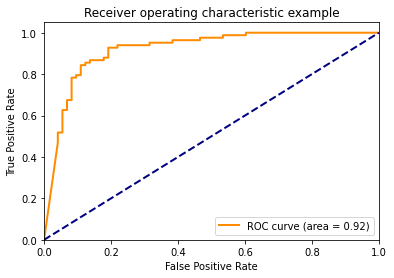

Epoch 1/40
39/39 [==============================] - 18s 469ms/step - loss: 11.4013 - dense_26_loss: 4.4747 - dense_18_loss: 0.8329 - dense_19_loss: 0.7718 - dense_20_loss: 0.7835 - dense_21_loss: 1.3201 - dense_22_loss: 0.7728 - dense_23_loss: 0.6436 - dense_24_loss: 0.6618 - dense_25_loss: 1.1402 - dense_26_AUC: 0.6684 - dense_26_Precision: 0.6433 - dense_26_TP: 202.0000 - dense_26_FP: 112.0000 - dense_26_TN: 206.0000 - dense_26_FN: 103.0000 - dense_26_acc: 0.6549 - dense_18_AUC: 0.6489 - dense_18_Precision: 0.5926 - dense_18_TP: 192.0000 - dense_18_FP: 132.0000 - dense_18_TN: 186.0000 - dense_18_FN: 113.0000 - dense_18_acc: 0.6067 - dense_19_AUC: 0.6618 - dense_19_Precision: 0.6087 - dense_19_TP: 182.0000 - dense_19_FP: 117.0000 - dense_19_TN: 201.0000 - dense_19_FN: 123.0000 - dense_19_acc: 0.6148 - dense_20_AUC: 0.6879 - dense_20_Precision: 0.6194 - dense_20_TP: 192.0000 - dense_20_FP: 118.0000 - dense_20_TN: 200.0000 - dense_20_FN: 113.0000 - dense_20_acc: 0.6292 - dense_21_AUC: 0

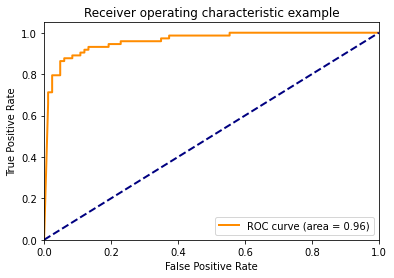

Epoch 1/40
39/39 [==============================] - 18s 466ms/step - loss: 10.4384 - dense_35_loss: 4.1823 - dense_27_loss: 0.7470 - dense_28_loss: 0.7182 - dense_29_loss: 0.6930 - dense_30_loss: 1.2584 - dense_31_loss: 0.6742 - dense_32_loss: 0.5933 - dense_33_loss: 0.6181 - dense_34_loss: 0.9539 - dense_35_AUC: 0.7028 - dense_35_Precision: 0.6772 - dense_35_TP: 214.0000 - dense_35_FP: 102.0000 - dense_35_TN: 207.0000 - dense_35_FN: 100.0000 - dense_35_acc: 0.6758 - dense_27_AUC: 0.7045 - dense_27_Precision: 0.6547 - dense_27_TP: 201.0000 - dense_27_FP: 106.0000 - dense_27_TN: 203.0000 - dense_27_FN: 113.0000 - dense_27_acc: 0.6485 - dense_28_AUC: 0.6883 - dense_28_Precision: 0.6525 - dense_28_TP: 199.0000 - dense_28_FP: 106.0000 - dense_28_TN: 203.0000 - dense_28_FN: 115.0000 - dense_28_acc: 0.6453 - dense_29_AUC: 0.7344 - dense_29_Precision: 0.6885 - dense_29_TP: 210.0000 - dense_29_FP: 95.0000 - dense_29_TN: 214.0000 - dense_29_FN: 104.0000 - dense_29_acc: 0.6806 - dense_30_AUC: 0.

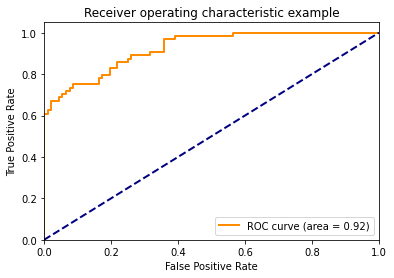

Epoch 1/40
39/39 [==============================] - 18s 473ms/step - loss: 10.3134 - dense_44_loss: 3.8668 - dense_36_loss: 0.7982 - dense_37_loss: 0.7336 - dense_38_loss: 0.7427 - dense_39_loss: 1.4558 - dense_40_loss: 0.6185 - dense_41_loss: 0.5680 - dense_42_loss: 0.5893 - dense_43_loss: 0.9405 - dense_44_AUC: 0.7325 - dense_44_Precision: 0.6708 - dense_44_TP: 216.0000 - dense_44_FP: 106.0000 - dense_44_TN: 214.0000 - dense_44_FN: 88.0000 - dense_44_acc: 0.6891 - dense_36_AUC: 0.6693 - dense_36_Precision: 0.6319 - dense_36_TP: 182.0000 - dense_36_FP: 106.0000 - dense_36_TN: 214.0000 - dense_36_FN: 122.0000 - dense_36_acc: 0.6346 - dense_37_AUC: 0.6835 - dense_37_Precision: 0.6443 - dense_37_TP: 192.0000 - dense_37_FP: 106.0000 - dense_37_TN: 214.0000 - dense_37_FN: 112.0000 - dense_37_acc: 0.6506 - dense_38_AUC: 0.7128 - dense_38_Precision: 0.6352 - dense_38_TP: 202.0000 - dense_38_FP: 116.0000 - dense_38_TN: 204.0000 - dense_38_FN: 102.0000 - dense_38_acc: 0.6506 - dense_39_AUC: 0.

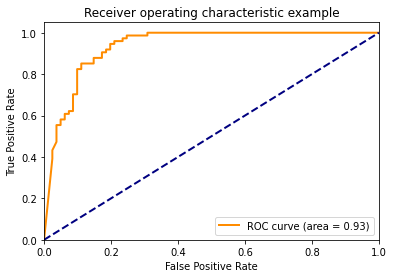

In [18]:
from sklearn.model_selection import KFold
from sklearn import metrics
y_trues = []
y_preds = []
AUC = tf.keras.metrics.AUC(name = 'AUC')
Precision = tf.keras.metrics.Precision(name = 'Precision')
TP = tf.keras.metrics.TruePositives(name = 'TP')
FP = tf.keras.metrics.FalsePositives(name = 'FP')
TN = tf.keras.metrics.TrueNegatives(name = 'TN')
FN = tf.keras.metrics.FalseNegatives(name = 'FN')
tps = 0
fps = 0
tns = 0
fns = 0
kf = KFold(n_splits=5,random_state=10, shuffle=True)
for train_index, test_index in kf.split(subjects):
    test = [subjects[i] for i in test_index]
    train = [subjects[i] for i in train_index]
    
    train_gen = SubjectGenerator(train,batch_size = 16,shuffle = True,MO=True)
    test_gen = SubjectGenerator(test,batch_size=16,MO=True)
    baselin2 = Leaky_EfficientNet2()
    baselin2.compile(optimizer = tf.keras.optimizers.Adadelta(lr = 0.1,rho = 0.1),loss = 'binary_crossentropy',metrics = [AUC,Precision,TP,FP,TN,FN,'acc'])
    baselin2.fit_generator(train_gen,epochs = 40, verbose=1)
    y_true = test_gen.get_labels()
    y_pred = baselin2.predict_generator(test_gen)
    y_trues.append(y_true)
    y_preds.append(y_pred[0])
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred[0])
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    eva = baselin2.evaluate_generator(test_gen)
    tp,fp,tn,fn = eva[12:16]
    tps += tp
    fps += fp
    tns += tn
    fns += fn

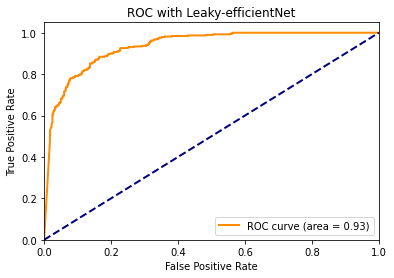

In [19]:
y_true = np.concatenate([y_trues[0],y_trues[1],y_trues[2],y_trues[3],y_trues[4]])
y_pred = np.concatenate([y_preds[0],y_preds[1],y_preds[2],y_preds[3],y_preds[4]])
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with Leaky-efficientNet')
plt.legend(loc="lower right")
plt.show()

In [24]:
demo_model = Leaky_EfficientNet()
demo_model.load_weights('efficient_Leaky.h5')

def demo(subject):
    y_true = subject.label
    addr = subject.addr
    start = subject.start
    x1 = start[0]['x']
    y1 = start[0]['y']
    z1 = start[0]['z']
    x2 = start[1]['x']
    y2 = start[1]['y']
    z2 = start[1]['z']
    names = os.listdir(addr)
    names.sort()
    
    item_gen = SubjectGenerator([subject])
    pred = demo_model.predict_generator(item_gen)
    y_pred = int(round(pred[0][0]))
    labels = ['benign','malignant']
    print('ground-truth : ',labels[y_true])
    print('prediction : ',labels[y_pred])
    print('===============================================')
    print('===============================================')
    print('===============================================')
    
    
    z = 10
    
    for i in range(z1,z1+10):
        name ='{0:06}'.format(i) + '.dcm'
        pic = pydicom.dcmread(os.path.join(addr,name)).pixel_array

        fig,ax = plt.subplots(1)
            
        # Display the image
        ax.imshow(pic,cmap='gray')

        #Create a Rectangle patch
        rect = patches.Rectangle((x1,y1),100,100,linewidth=1,edgecolor='r',facecolor='none')
        if (i>=z2 and i< z2 + 5):
            rect2 = patches.Rectangle((x2,y2),50,50,linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect2)

        ax.add_patch(rect)
        plt.axis('off')
        plt.show()
    
    
    
    

ground-truth :  malignant
prediction :  malignant


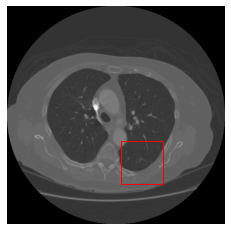

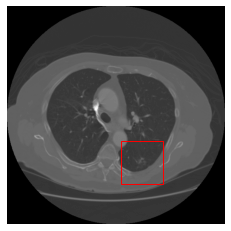

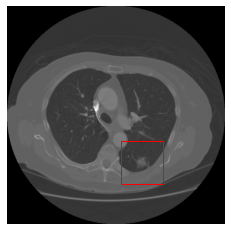

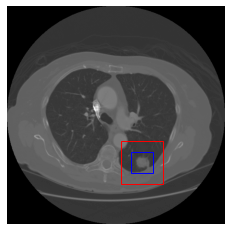

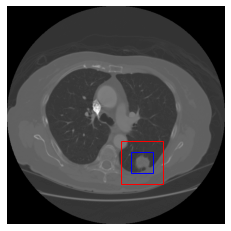

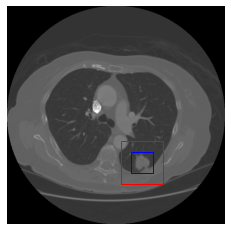

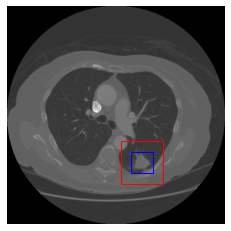

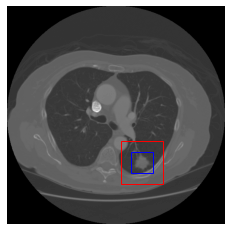

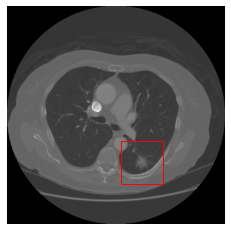

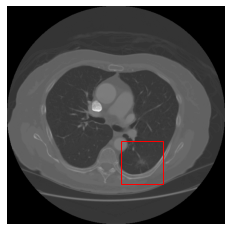

In [26]:
#all of subjects  : 779
demo(subjects[0])

In [45]:
def demo1(subject):
    y_true = subject.label
    addr = subject.addr
    start = subject.start
    x1 = start[0]['x']
    y1 = start[0]['y']
    z1 = start[0]['z']
    x2 = start[1]['x']
    y2 = start[1]['y']
    z2 = start[1]['z']
    names = os.listdir(addr)
    names.sort()
    
    
    name ='{0:06}'.format(z1 + 4) + '.dcm'
    pic = pydicom.dcmread(os.path.join(addr,name)).pixel_array
    
    plt.imshow(pic[y1:y1+100,x1:x1+100],cmap='gray')
    


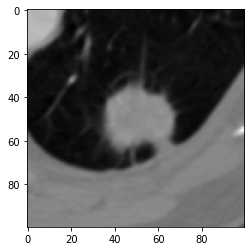

In [46]:
demo1(subjects[0])